# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# План

1. **Загрузка и ознакомление с данными:** получить датасеты, ознакомиться и соотнести данные с описание этапов обработки металла. Соберем признаки в одном датасете.
2. **Подготовка данных:** выделить наиболее значимые данные, которое станут признаками для обучения. Провести предобработку данных: удалить пропуски, явные дубликаты, выбросы и т.д.
3. **Исследовательский анализ:** построить и проанализировать графики распределения и зависимости данных.
4. **Обучение модели:** собрать единый датафрейм данных, разделить выборку, провести масштабирование и, если понадобиться, кодирование признаков. Взять основые модели для предсказания регрессии и провести кроссвалидацию с подбором различных гиперпараметров. Выбрать лучшую модель.
5. **Тестирование лучшей модели:** Провести анализ работоспособности выбранной модели, сравнить результаты с dummy model.
6. **Вывод**

In [1]:
!pip install -q catboost
!pip install -q lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [3]:
#CONSTANS
RANDOM_STATE = 270323

## Загрузка и ознакомление с данными

In [4]:
try:
    data_arc = pd.read_csv('C:/Users/rusla/Jupyter/Data/data_arc.csv', parse_dates=[1,2])
    data_bulk = pd.read_csv('C:/Users/rusla/Jupyter/Data/data_bulk.csv', index_col = 'key')
    data_bulk_time = pd.read_csv('C:/Users/rusla/Jupyter/Data/data_bulk_time.csv', index_col = 'key', parse_dates=list(range(1, 16)))
    data_gas = pd.read_csv('C:/Users/rusla/Jupyter/Data/data_gas.csv', index_col = 'key')
    data_temp = pd.read_csv('C:/Users/rusla/Jupyter/Data/data_temp.csv', parse_dates=[1])
    data_wire = pd.read_csv('C:/Users/rusla/Jupyter/Data/data_wire.csv', index_col = 'key')
    data_wire_time = pd.read_csv('C:/Users/rusla/Jupyter/Data/data_wire_time.csv', index_col = 'key', parse_dates=list(range(1, 10)))
except: 
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=[1,2])
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', index_col = 'key')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', index_col = 'key', parse_dates=list(range(1, 16)))
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', index_col = 'key')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1])
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv', index_col = 'key')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', index_col = 'key', parse_dates=list(range(1, 10)))

In [5]:
print('Размер выборки об электродах:',data_arc.shape)
data_arc.head(10)

Размер выборки об электродах: (14876, 5)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [6]:
print('Размер выборки измерения температуры:',data_temp.shape)
data_temp.head(10)

Размер выборки измерения температуры: (15907, 3)


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [7]:
print('Размер выборки о подаче сыпучих материалов (объём):',data_bulk.shape)
data_bulk.head(10)

Размер выборки о подаче сыпучих материалов (объём): (3129, 15)


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0


In [8]:
print('Размер выборки о подаче сыпучих материалов (время):',data_bulk_time.shape)
data_bulk_time.head(10)

Размер выборки о подаче сыпучих материалов (время): (3129, 15)


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
6,NaT,NaT,NaT,2019-05-03 13:59:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:53:27,NaT,2019-05-03 13:53:27,2019-05-03 13:53:27
7,NaT,NaT,NaT,2019-05-03 14:29:14,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:22:19,NaT,2019-05-03 14:22:19,2019-05-03 14:22:19
8,NaT,NaT,NaT,2019-05-03 15:04:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:55:46,NaT,2019-05-03 14:55:46,2019-05-03 14:55:46
9,NaT,NaT,NaT,2019-05-03 15:47:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 15:41:00,NaT,2019-05-03 15:41:00,2019-05-03 15:41:00


In [9]:
print('Размер выборки о продувке сплава газом:',data_gas.shape)
data_gas.head()

Размер выборки о продувке сплава газом: (3239, 1)


,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [10]:
print('Размер выборки о проволочных материалах (объём):',data_wire.shape)
data_wire.head()

Размер выборки о проволочных материалах (объём): (3081, 9)


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print('Размер выборки о проволочных материалах (время):',data_wire_time.shape)
data_wire_time.head()

Размер выборки о проволочных материалах (время): (3081, 9)


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<b>Комментарий:  Поочередно рассмотрим данные датасетов на распределение, выбросы и аномалии.</b></font> 

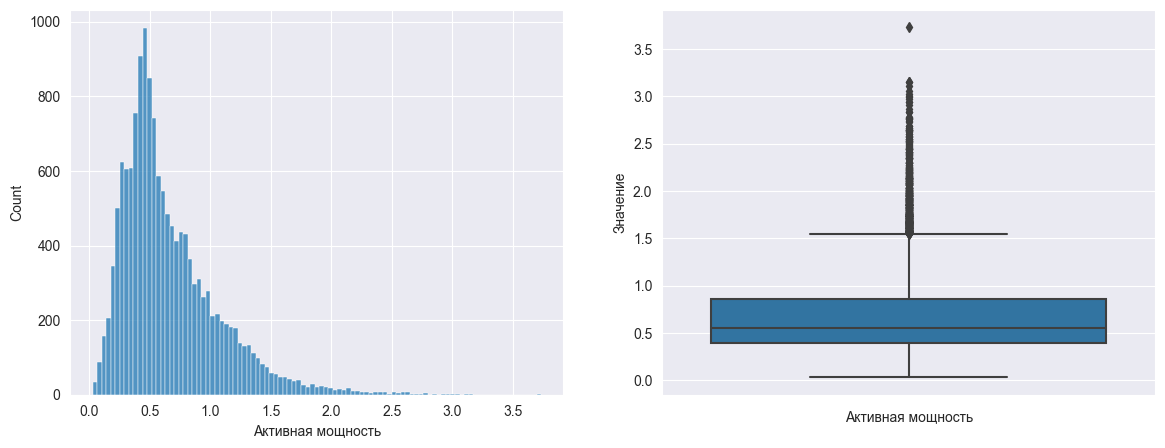

In [12]:
sns.set_style("darkgrid")
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.histplot(data=data_arc['Активная мощность'], ax=ax1)
sns.boxplot(data=data_arc, ax=ax2, y='Активная мощность');
ax2.set(xlabel='Активная мощность', ylabel='Значение');

<b>Комментарий:  По графику распределения значений активной мощность можно заметить схожесть с нормальным распределением. Есть лишь немного выбросов, о чем свидетельствует ящик с усами.</b></font>

In [13]:
data_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

In [14]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

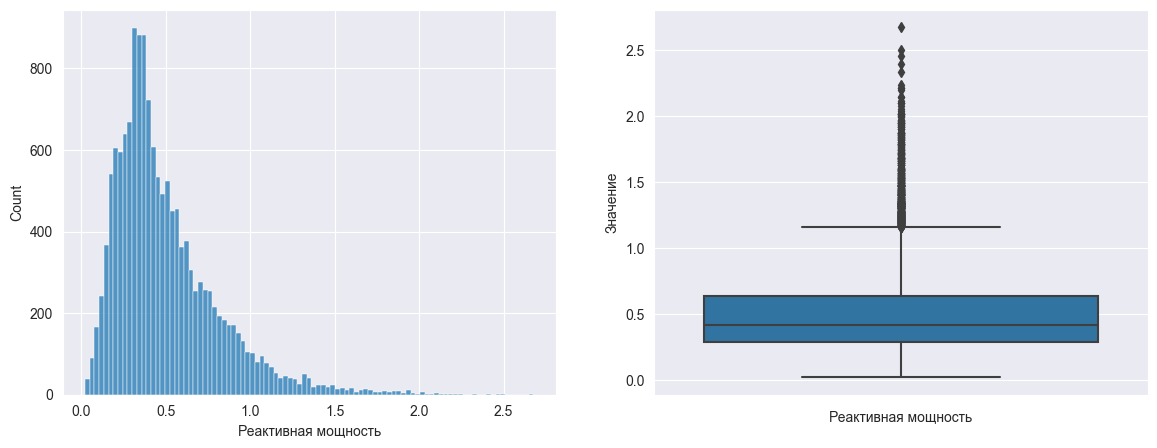

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.histplot(data=data_arc['Реактивная мощность'], ax=ax1)
sns.boxplot(data=data_arc, ax=ax2, y='Реактивная мощность');
ax2.set(xlabel='Реактивная мощность', ylabel='Значение');

<b>Комментарий:  В данных реактивной мощности есть аномалия в виде одного большого отрицательного значения, она всего одна, поэтому можем убрать. Остальные данные по характеру похожи на активную мощность.</b></font>

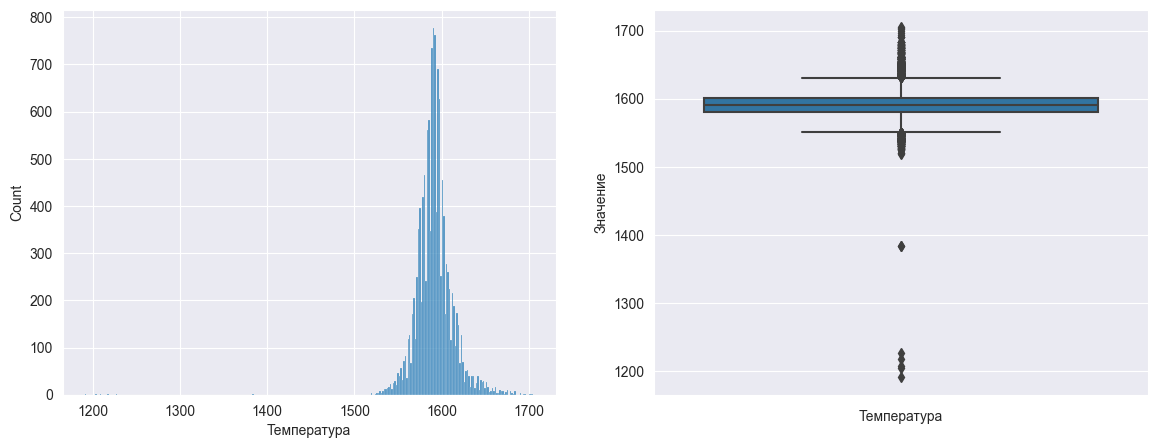

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.histplot(data=data_temp['Температура'], ax=ax1)
sns.boxplot(data=data_temp, ax=ax2, y='Температура');
ax2.set(xlabel='Температура', ylabel='Значение');

<b>Комментарий: Распределение температуры сильно похоже на нормальное, имеются некоторые выбросы. Удалять их не вижу смысла, поскольку дальше будет деление температуры на начальную и конечную. Конечную нам как раз необходимо будет предсказывать. А выбросы начальной обработаем позже.</b></font> 

In [17]:
data_wire.describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


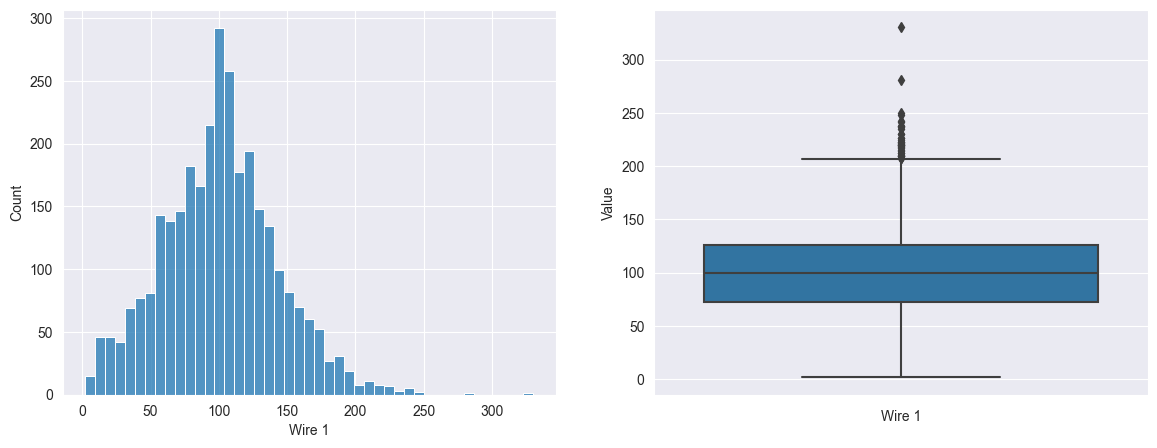

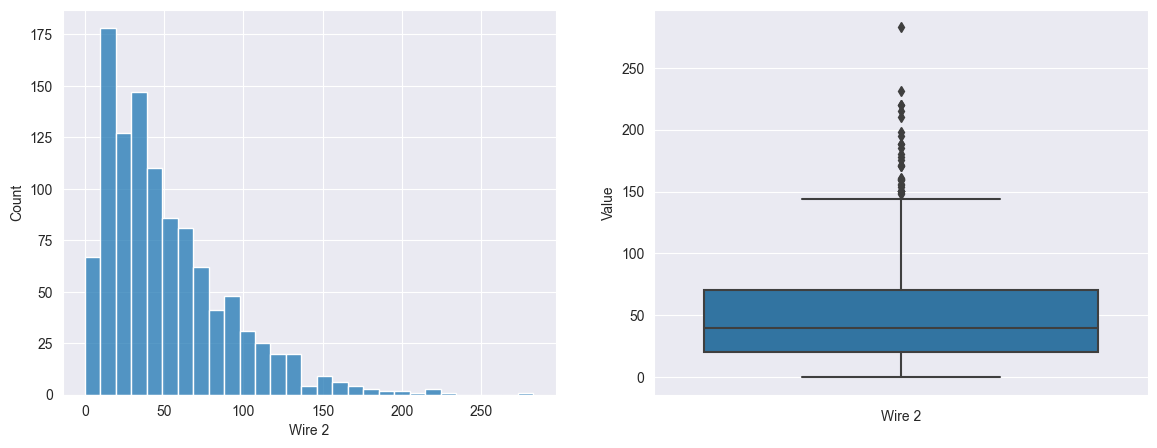

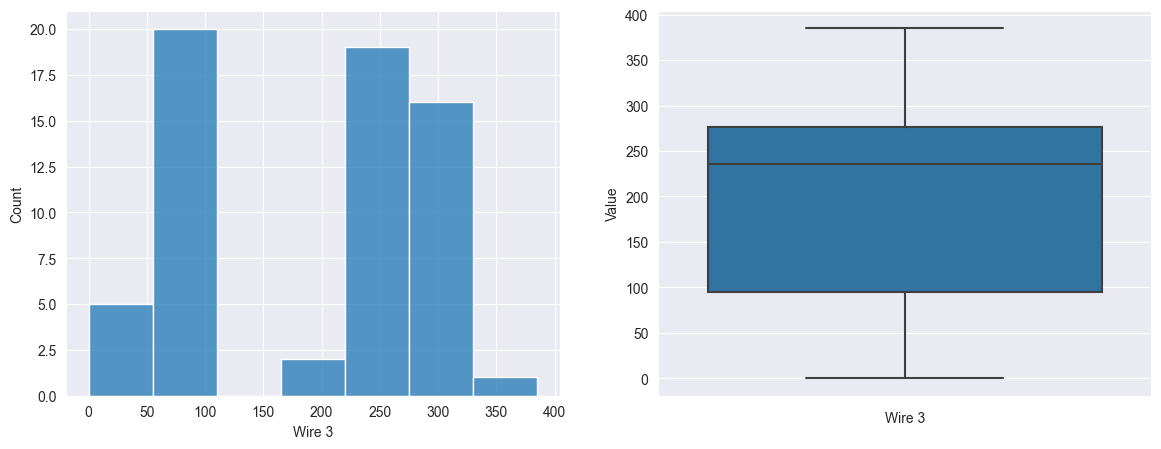

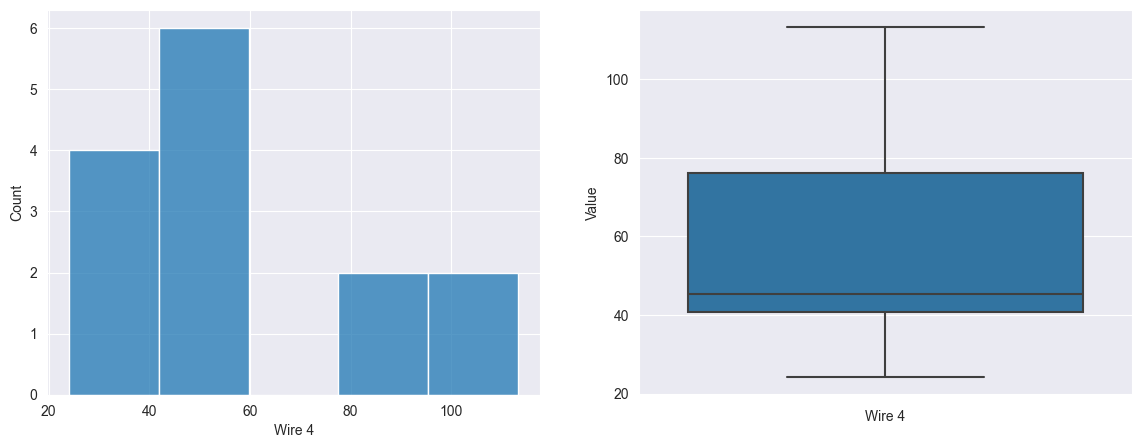

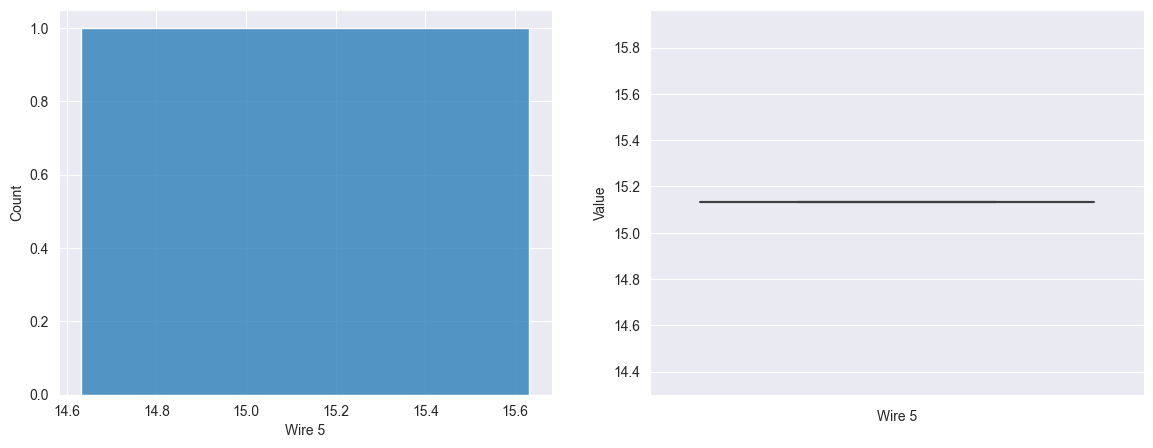

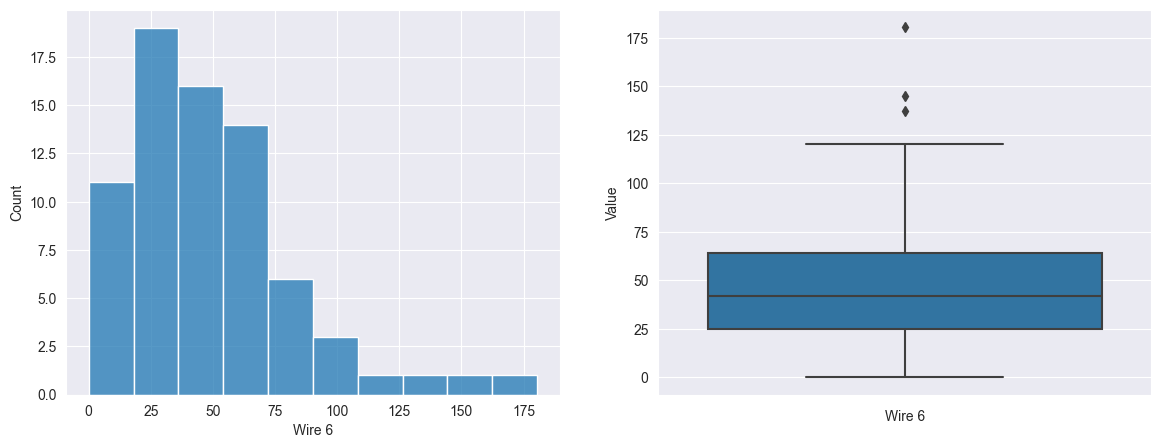

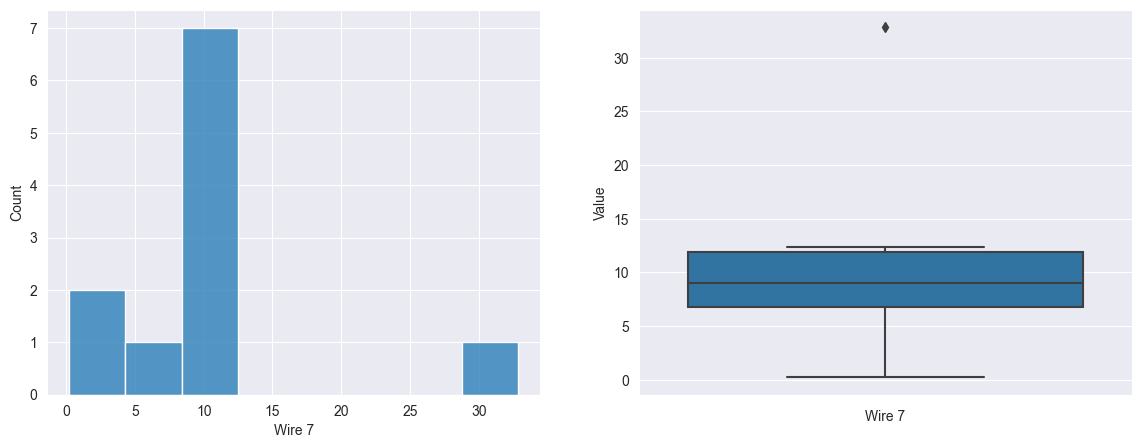

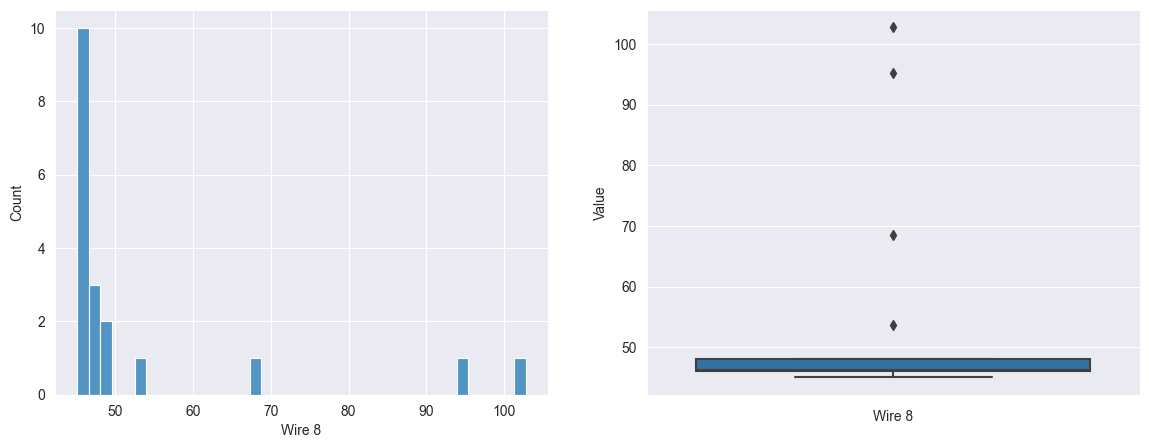

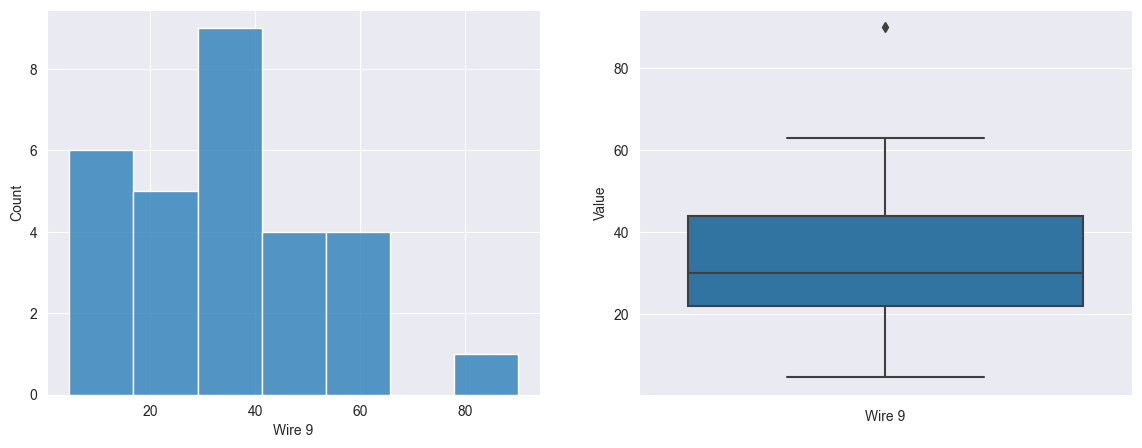

In [18]:
for column in data_wire.columns:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
    sns.histplot(data=data_wire[column], ax=ax1)
    sns.boxplot(data=data_wire, ax=ax2, y=column);
    ax2.set(xlabel=column, ylabel='Value');

<b>Комментарий: Выбросы имеются, однако тяжело их оценивать, где-то в виду малого количества данных, почти нет распределений похожих на нормальное, но основной проблемой является факт того что у нас нет каких-либо сведений о конечном продукте. Добавки проволочных материлов необходимы для получения определенного сплава, возможно так, что концентрация сильно отлицается для получения другого отличного. Есть лишь точные сведение о том, что сплавы делают разные. По моему мнению, малое количетсво данных в некоторых столбцах и отсутсвие знания о формировании сплавов и концентрации тех или иных видов проволочных материалов, дают основание не удалять выбросы.</b></font>


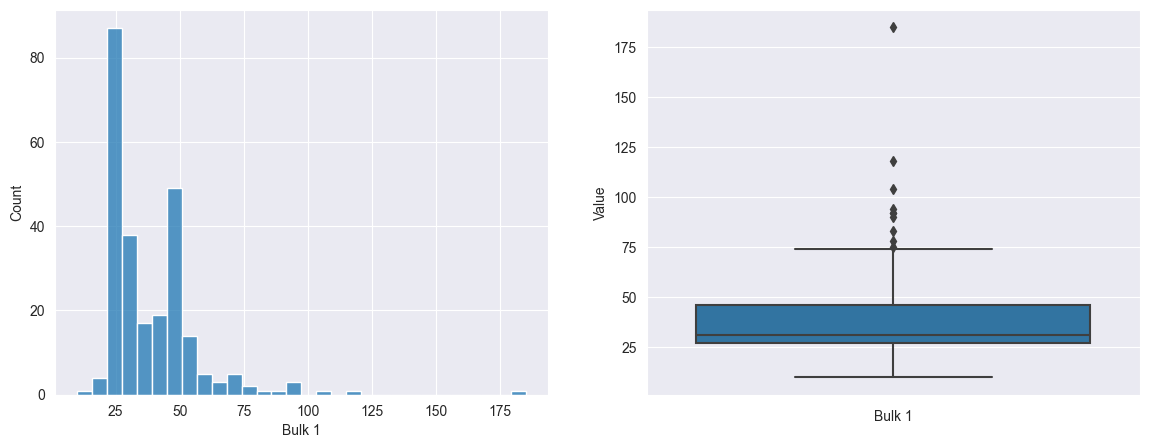

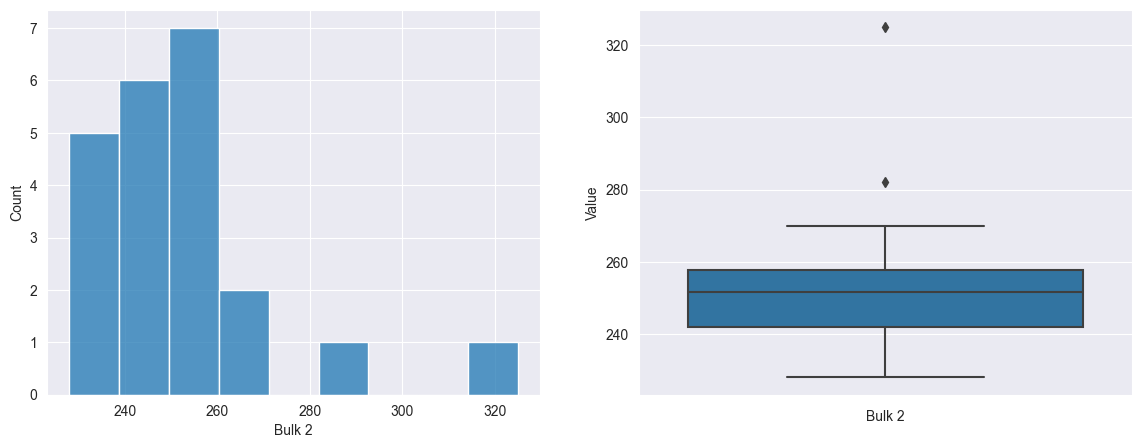

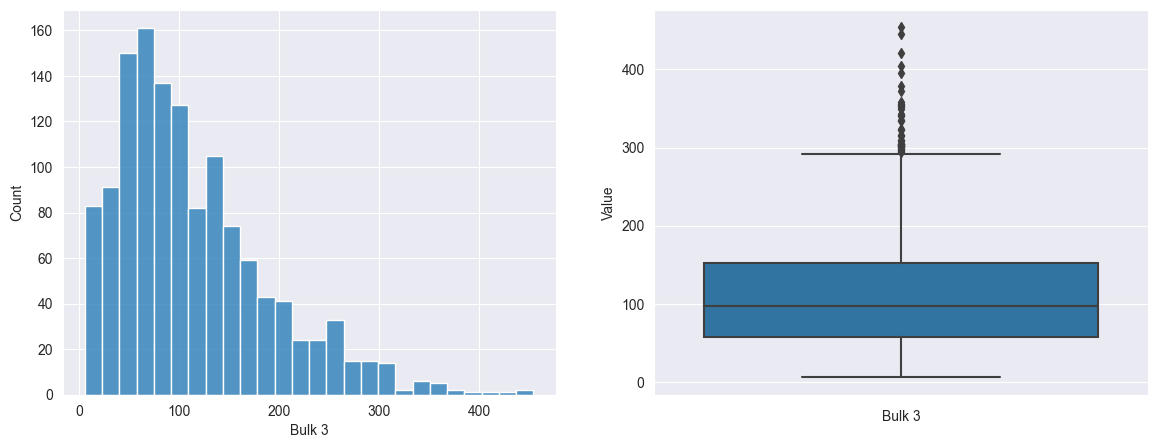

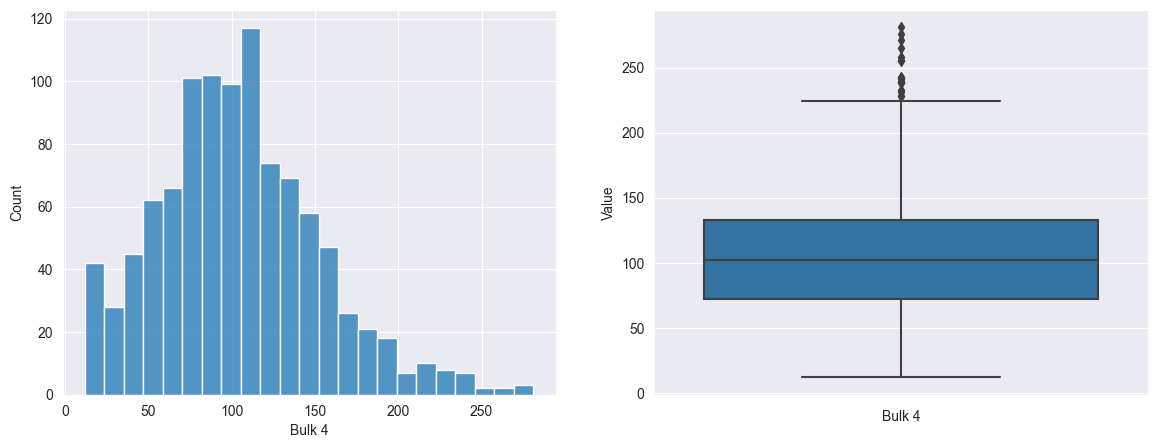

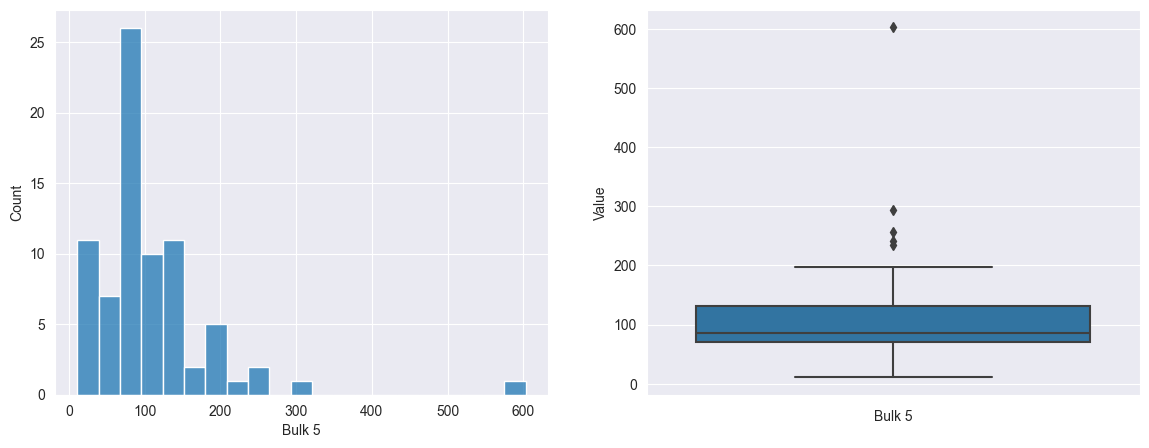

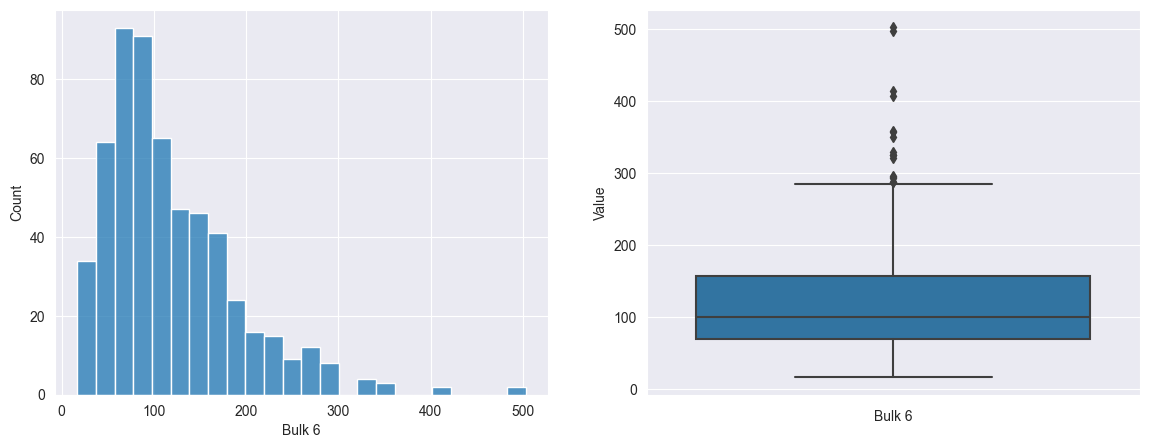

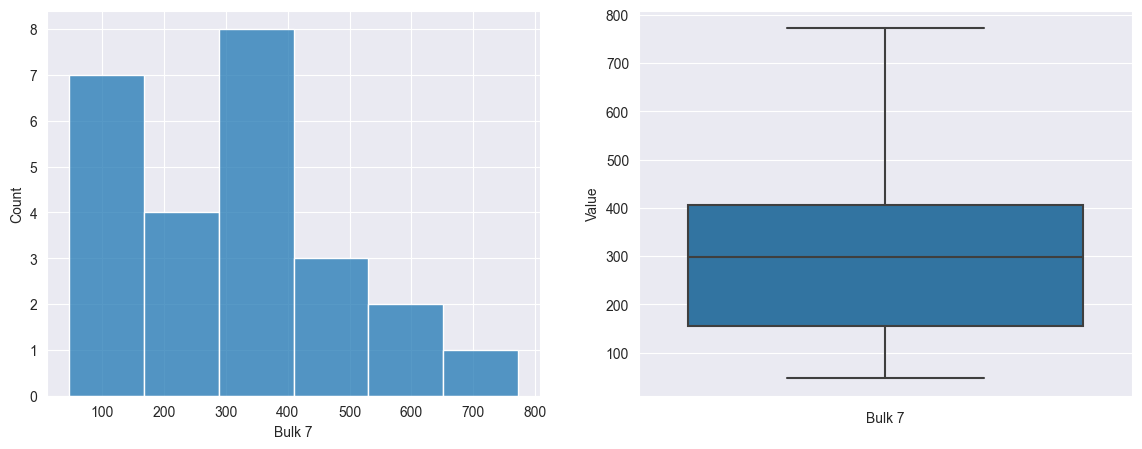

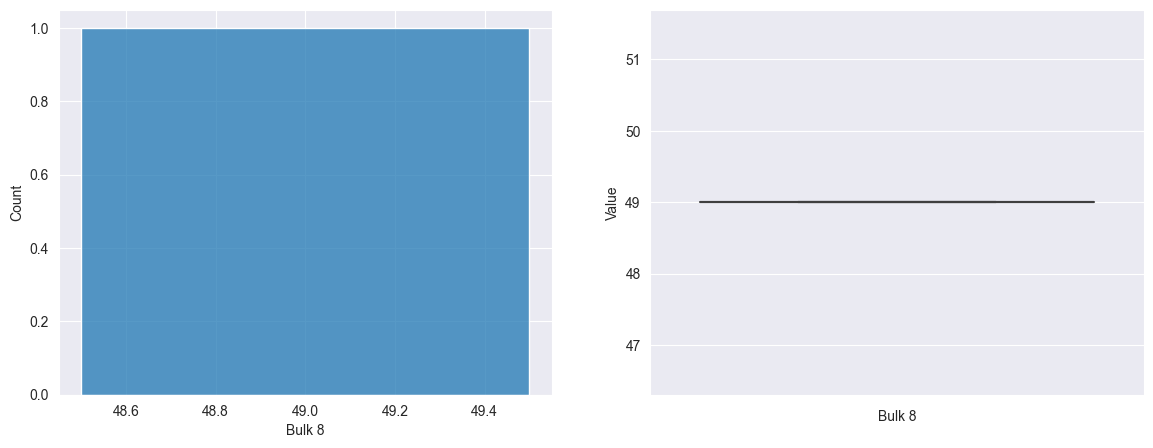

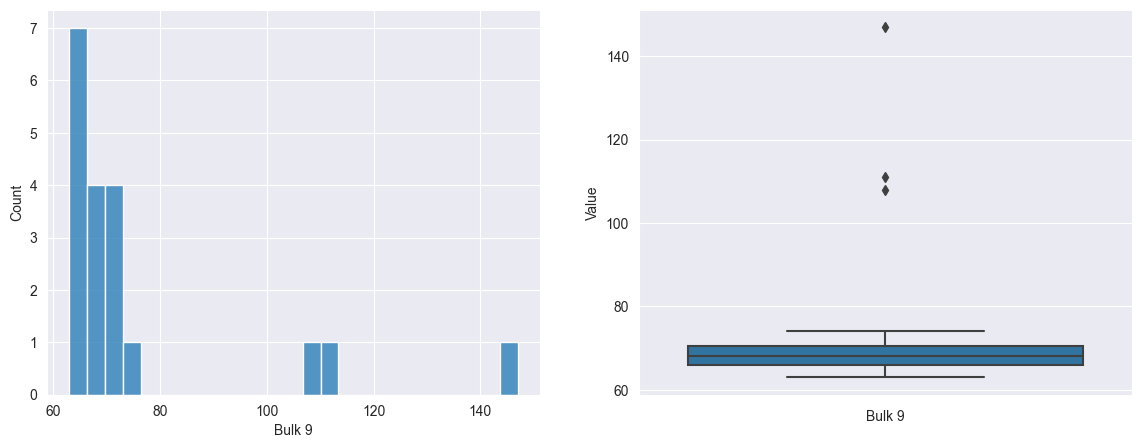

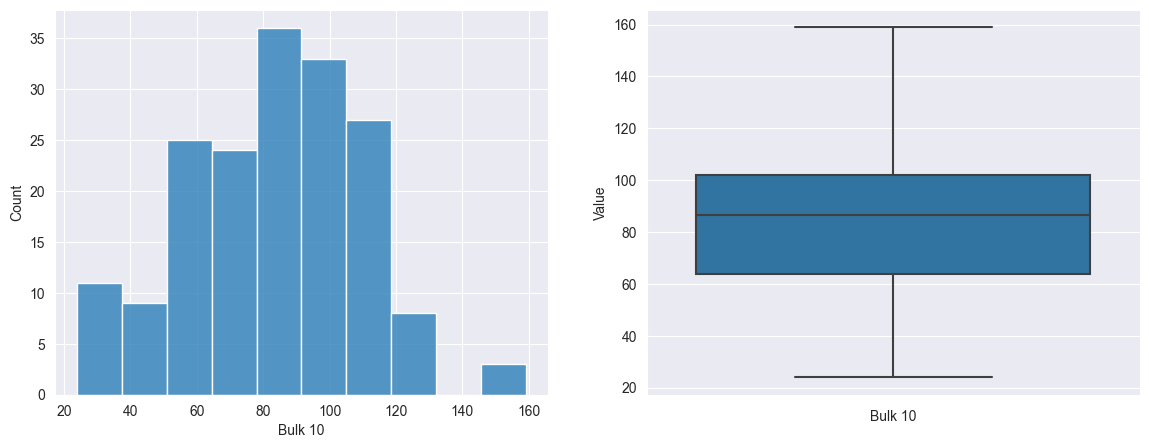

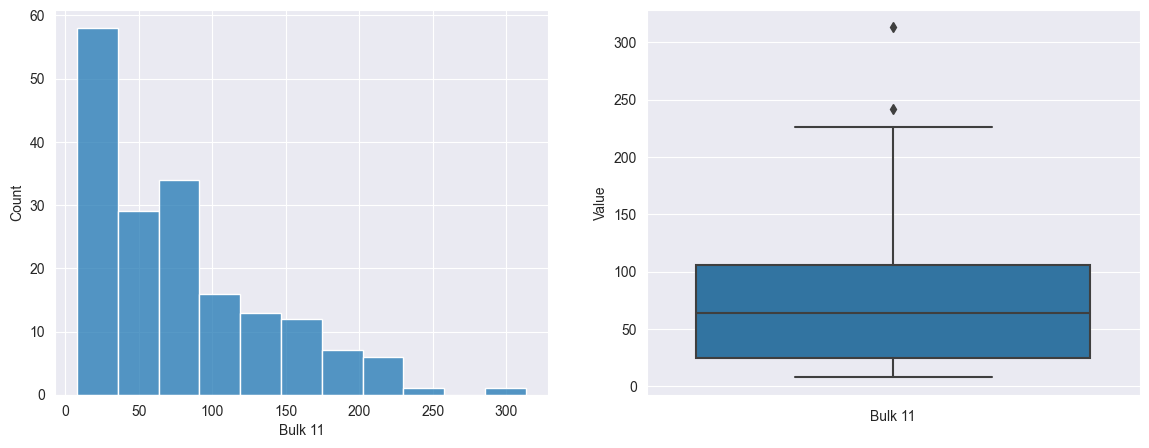

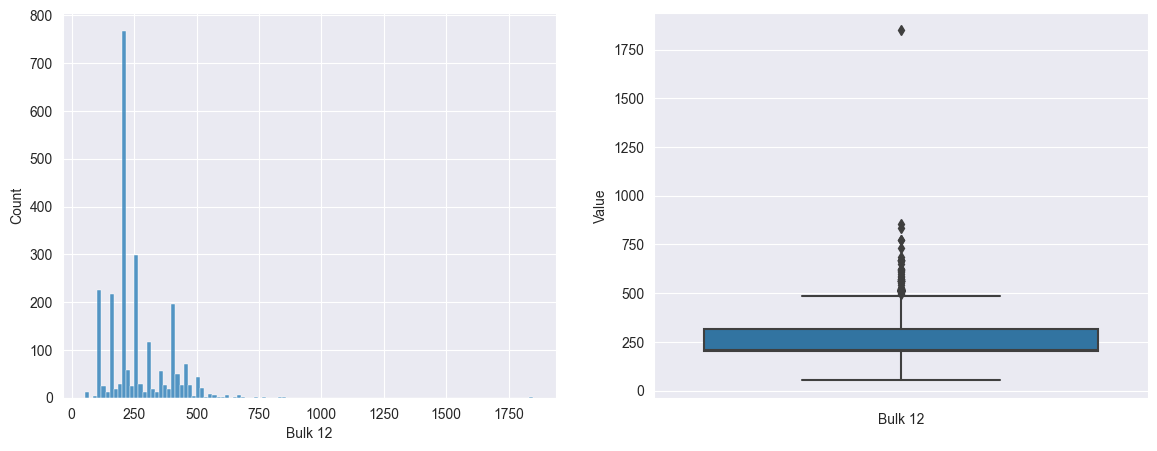

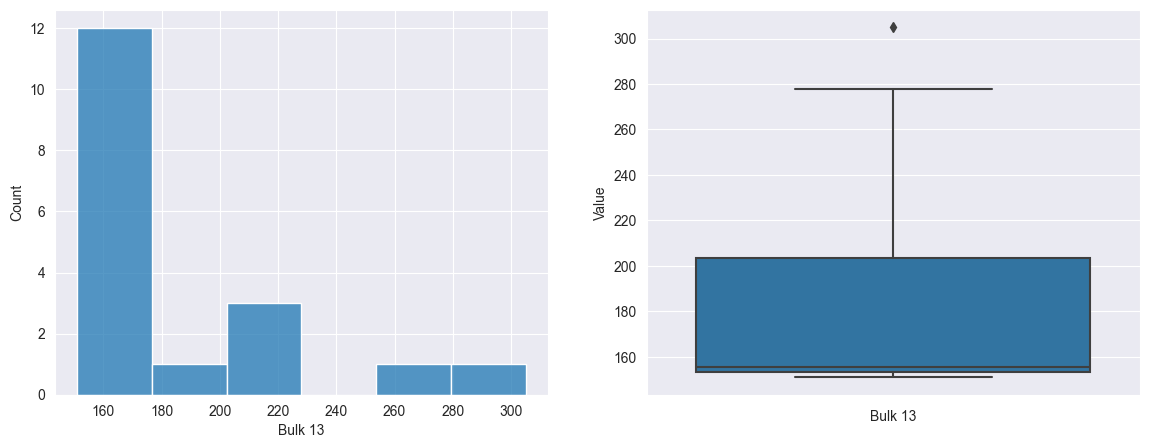

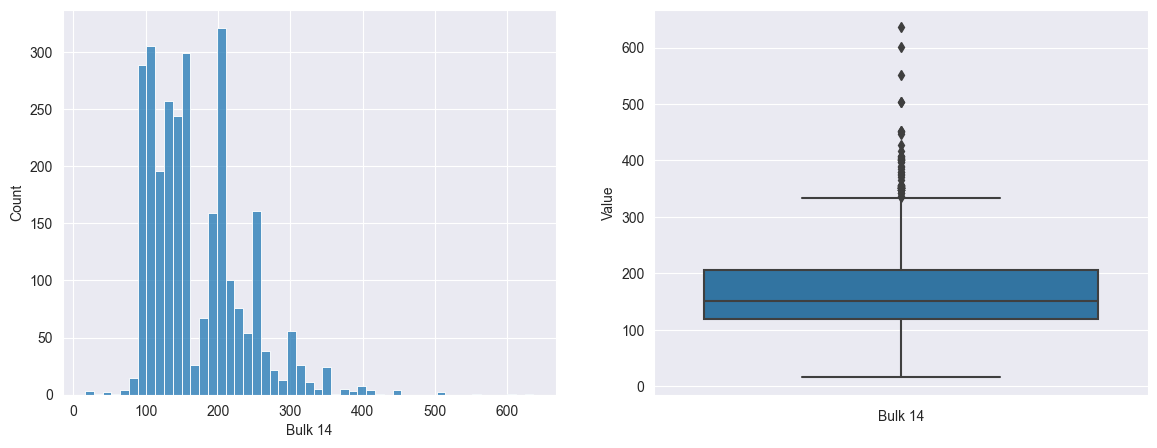

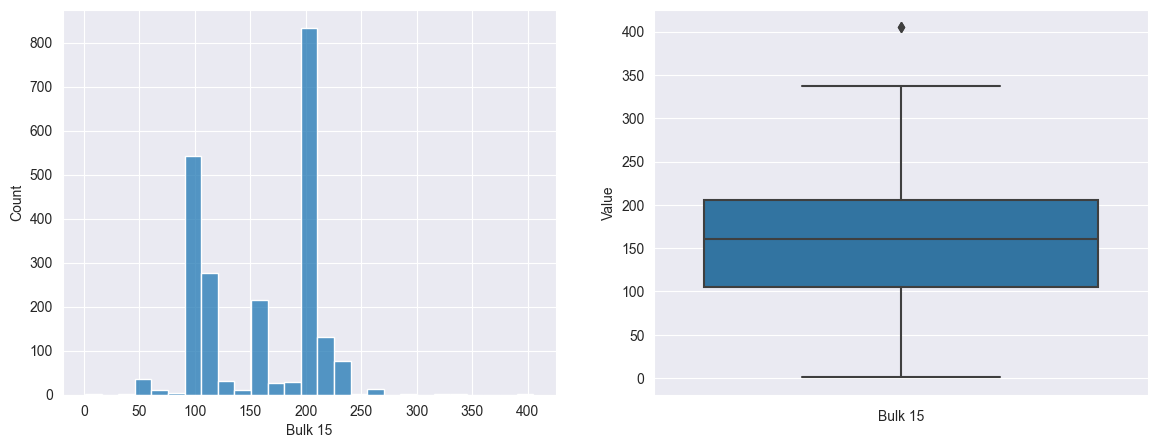

In [19]:
for column in data_bulk.columns:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
    sns.histplot(data=data_bulk[column], ax=ax1)
    sns.boxplot(data=data_bulk, ax=ax2, y=column);
    ax2.set(xlabel=column, ylabel='Value');

<b>Комментарий:  С сыпучими материалами вывод аналогичен проволочным.</b></font>

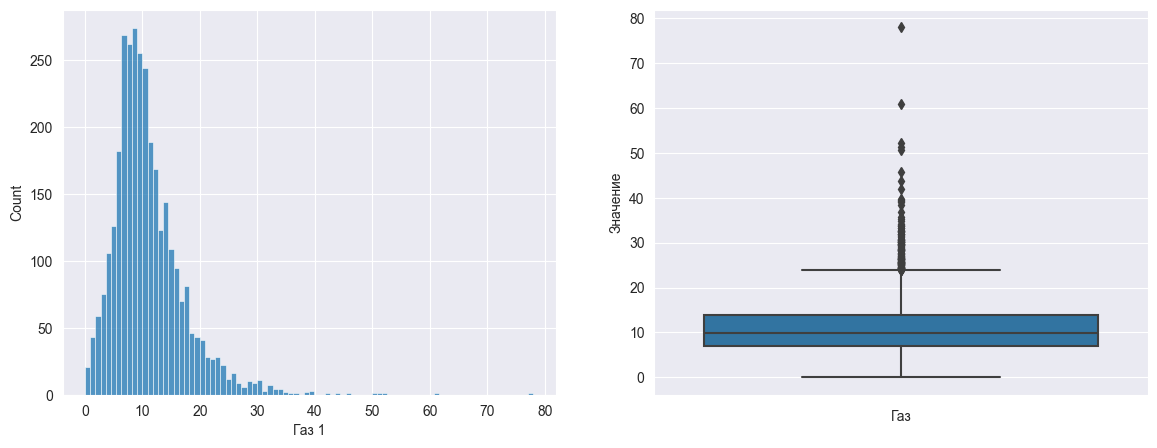

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
sns.histplot(data=data_gas['Газ 1'], ax=ax1)
sns.boxplot(data=data_gas, ax=ax2, y='Газ 1');
ax2.set(xlabel='Газ', ylabel='Значение');

<b>Комментарий: Распределение похоже на нормальное, имеются некоторые выбросы.</b></font>

<b>Комментарий:  Постараюсь кратко описать как я понял производственный процесс, а также что дал поверхностный анализ имеющихся данных. Мы имеем дело с процессом легирования и изменения химического состава стали посредством добавления различных примесей (сыпучих и проволочных материалов). Кроме того сталь обдувают газом и при этом всем необходимо поддерживать опеределенную температуру. Хотел бы выделить тот факт, что для получение того или иного типа стали используется разный набор и количество проволочных и сыпучих материалов. Временные промежутки в соответствующих датасетах дают нам понимание об этом.</b></font>

<b>Комментарий: Нашим целевым признаком является конечная температура. Использовать время в качестве признаков я считаю не целесообразным, время может дать понимание последовательности получения одного конкретного сплава, но так как информации о сплавах нет в датасете и описании, это облегчает наше понимание процесса работы производства, но не целесообразно к использованию в обучении. Кроме того, процессы скорее всего не автоматизированны, все выполняется с нажатия кнопки человеком, поэтому я считаю что никакой зависимости времени от конечной температуры мы получить не сможем.
</b></font>

<b>Комментарий: Перейдем в формированию датасета для обучения, начнем с data_temp, где важными признаками будет из данной выборки первая и последняя снятые с датчика температуры.
</b></font>

In [21]:
data = pd.DataFrame(index = data_temp['key'].unique(),columns=['first_temp', 'last_temp'])
for i in data_temp['key'].unique():
    temp_array = list(data_temp[data_temp['key'] == i]['Температура'])
    data.loc[i] = [temp_array[0],temp_array[-1]]

In [22]:
print('Количество данных в обработанном датасете:',data.shape)
data.head()

Количество данных в обработанном датасете: (3216, 2)


,first_temp,last_temp
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [23]:
data.describe()

,first_temp,last_temp
count,3216.0,2477.0
unique,148.0,106.0
top,1588.0,1593.0
freq,68.0,134.0


<b>Комментарий: Теперь перейдем к добавлению данных об электродах. Хочу отметить, что данные о времени и реактивной мощности нас не интересует. Только активная мощность идет на нагревание температуры и от нее зависит конечная температура, поэтому добавим только ее, суммировав на всех итерациях.</b></font>

In [24]:
data = data.join(data_arc.groupby('key')['Активная мощность'].sum(), how='inner')
data.rename(columns = {'Активная мощность':'active_power'}, inplace = True)
print('Количество данных в обработанном датасете:',data.shape)
data.head()

Количество данных в обработанном датасете: (3214, 3)


,first_temp,last_temp,active_power
1,1571.0,1613.0,4.878147
2,1581.0,1602.0,3.052598
3,1596.0,1599.0,2.525882
4,1601.0,1625.0,3.209250
5,1576.0,1602.0,3.347173


<b>Комментарий: Теперь добавим данные об сыпучих и проволочных материалах, предварительно все NaN заменим на 0, имея в виду, что этот материал не добавляли, значит его объем 0.
</b></font>

In [25]:
data = data.join(data_bulk.fillna(0), how='inner')
data = data.join(data_wire.fillna(0), how='inner')

In [26]:
print('Количество данных в обработанном датасете:',data.shape)
data.head()

Количество данных в обработанном датасете: (3024, 27)


,first_temp,last_temp,active_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1,1571.0,1613.0,4.878147,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,3.052598,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,2.525882,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,3.209250,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,3.347173,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b>Комментарий: Аналогичным образом присоединим данные о продувке сплава газом.
</b></font>

In [27]:
data = data.join(data_gas, how='inner')
data.rename(columns = {'Газ 1':'gas'}, inplace = True)

In [28]:
print('Количество данных в обработанном датасете:',data.shape)
data.head()

Количество данных в обработанном датасете: (3022, 28)


,first_temp,last_temp,active_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
1,1571.0,1613.0,4.878147,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1581.0,1602.0,3.052598,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,2.525882,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1601.0,1625.0,3.209250,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,3.347173,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


<b>Комментарий студента: После того, как все ключевые признаки собраны в одном датасете data, перейдем к подготовке данных.
</b></font>

## Подготовка данных

<b>Комментарий: Начнем с пропусков
</b></font>

In [29]:
data.isna().sum()

first_temp        0
last_temp       693
active_power      0
Bulk 1            0
Bulk 2            0
Bulk 3            0
Bulk 4            0
Bulk 5            0
Bulk 6            0
Bulk 7            0
Bulk 8            0
Bulk 9            0
Bulk 10           0
Bulk 11           0
Bulk 12           0
Bulk 13           0
Bulk 14           0
Bulk 15           0
Wire 1            0
Wire 2            0
Wire 3            0
Wire 4            0
Wire 5            0
Wire 6            0
Wire 7            0
Wire 8            0
Wire 9            0
gas               0
dtype: int64

<b>Комментарий: Большое количество пропусков в целевом признаке. Попытаемся разобраться в причине возникновения.
</b></font>

In [30]:
data_temp.tail(30)

,key,Время замера,Температура
15877,3236,2019-08-31 22:31:42,NaN
15878,3237,2019-08-31 22:44:04,1569.0
15879,3237,2019-08-31 22:44:44,NaN
15880,3237,2019-08-31 22:51:02,NaN
15881,3237,2019-08-31 23:01:16,NaN
15882,3237,2019-08-31 23:05:43,NaN
15883,3238,2019-08-31 23:30:31,1584.0
15884,3238,2019-08-31 23:37:26,NaN
15885,3238,2019-08-31 23:43:00,NaN
15886,3239,2019-09-01 01:31:47,1598.0


<b>Комментарий: В конце data_temp нет измерений, только начальная температура на key, скорее всего датчик температуры просто не измерил, других вариантов нет.
</b></font>

In [31]:
data.dropna(subset=['last_temp'], inplace = True)

In [32]:
print('Количество пропусков last_temp:',data['last_temp'].isna().sum())

Количество пропусков last_temp: 0


In [33]:
data.dtypes

first_temp       object
last_temp        object
active_power    float64
Bulk 1          float64
Bulk 2          float64
Bulk 3          float64
Bulk 4          float64
Bulk 5          float64
Bulk 6          float64
Bulk 7          float64
Bulk 8          float64
Bulk 9          float64
Bulk 10         float64
Bulk 11         float64
Bulk 12         float64
Bulk 13         float64
Bulk 14         float64
Bulk 15         float64
Wire 1          float64
Wire 2          float64
Wire 3          float64
Wire 4          float64
Wire 5          float64
Wire 6          float64
Wire 7          float64
Wire 8          float64
Wire 9          float64
gas             float64
dtype: object

In [34]:
print('Количество данных:', data.shape[0])

Количество данных: 2329


In [35]:
columns_to_int = data.columns.drop(['gas', 'active_power']).drop(data_wire.columns)
data[columns_to_int] = data[columns_to_int].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_temp    2329 non-null   int32  
 1   last_temp     2329 non-null   int32  
 2   active_power  2329 non-null   float64
 3   Bulk 1        2329 non-null   int32  
 4   Bulk 2        2329 non-null   int32  
 5   Bulk 3        2329 non-null   int32  
 6   Bulk 4        2329 non-null   int32  
 7   Bulk 5        2329 non-null   int32  
 8   Bulk 6        2329 non-null   int32  
 9   Bulk 7        2329 non-null   int32  
 10  Bulk 8        2329 non-null   int32  
 11  Bulk 9        2329 non-null   int32  
 12  Bulk 10       2329 non-null   int32  
 13  Bulk 11       2329 non-null   int32  
 14  Bulk 12       2329 non-null   int32  
 15  Bulk 13       2329 non-null   int32  
 16  Bulk 14       2329 non-null   int32  
 17  Bulk 15       2329 non-null   int32  
 18  Wire 1        2329 non-null 

<b>Комментарий: От пропусков избавились, теперь перейдем к поиску явных дубликатов и выбросов.
</b></font>

In [36]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


<b>Комментарий: Проверять на выбросы bulk и wire бессмысленно, так как весьма много нулей в некоторых данных, поэтому пройдемся по оставшимся. Предварительно разделим данные на тестовую и обучающую выборки.
</b></font>

In [37]:
features = data.drop('last_temp', axis=1)
target = data['last_temp']
print('features shape:', features.shape)
print('target shape:', target.shape)

features shape: (2329, 27)
target shape: (2329,)


In [38]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=RANDOM_STATE)
print('features_train shape:', features_train.shape, '||','features_test shape:', features_test.shape)
print('target_train shape:', target_train.shape, '||','target_test shape:', target_test.shape)

features_train shape: (1746, 27) || features_test shape: (583, 27)
target_train shape: (1746,) || target_test shape: (583,)


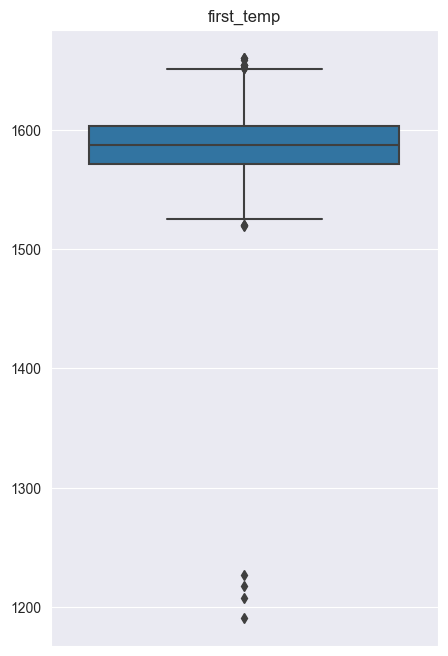

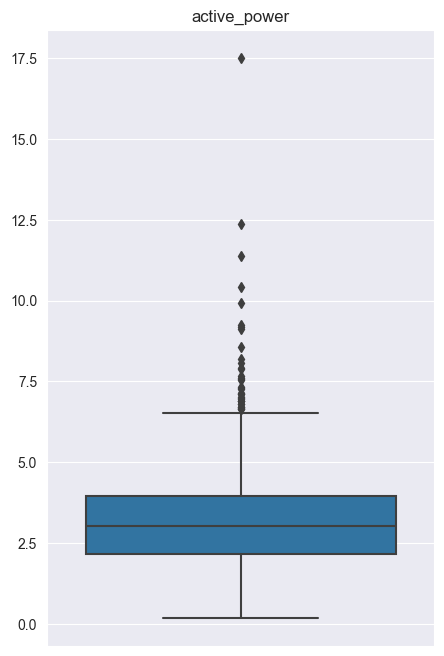

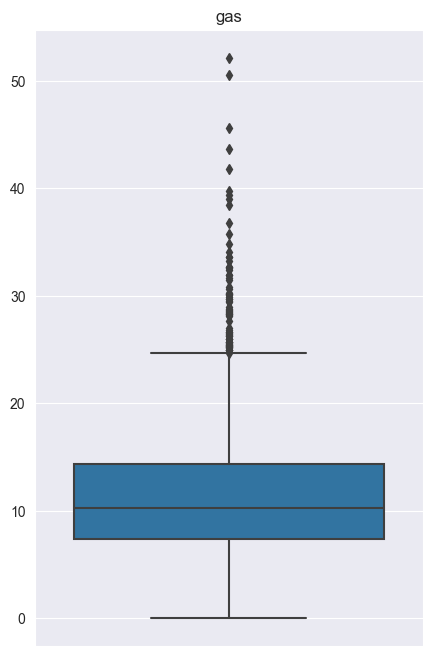

In [39]:
for column in ['first_temp', 'active_power', 'gas']:
    fig, ax = plt.subplots( figsize=(5,8))
    sns.boxplot(ax = ax, y=column,data=features_train)
    ax.set_title(column)
    ax.set(xlabel='', ylabel='')

In [40]:
sum_to_delete = 0
for column in ['first_temp', 'active_power', 'gas']:
    
    Q1 = features_train[column].quantile(q=.25)
    Q3 = features_train[column].quantile(q=.75)
    IQR = Q3-Q1
    
    to_delete = features_train[((features_train[column] < (Q1-1.5*IQR)) | (features_train[column] > (Q3+1.5*IQR)))].shape[0]
    sum_to_delete += to_delete
    
    print('К удалению ', column,': ', to_delete, sep='')
    features_train = features_train[~((features_train[column] < (Q1-1.5*IQR)) | (features_train[column] > (Q3+1.5*IQR)))]
    target_train = target_train[features_train[~((features_train[column] < (Q1-1.5*IQR)) | (features_train[column] > (Q3+1.5*IQR)))].index]
print('Всего удалено:', sum_to_delete)

К удалению first_temp: 16
К удалению active_power: 35
К удалению gas: 65
Всего удалено: 116


In [41]:
print('Количество данных:' , features_train.shape[0])

Количество данных: 1630


<b>Комментарий: К сожалению данных осталось мало, но, если обратить внимание на отсутсвие данных с целевым признаком, и не брать их удаление в рассчет, то осталось весьма неплохое количество данных.
</b></font>

## Исследовательский анализ

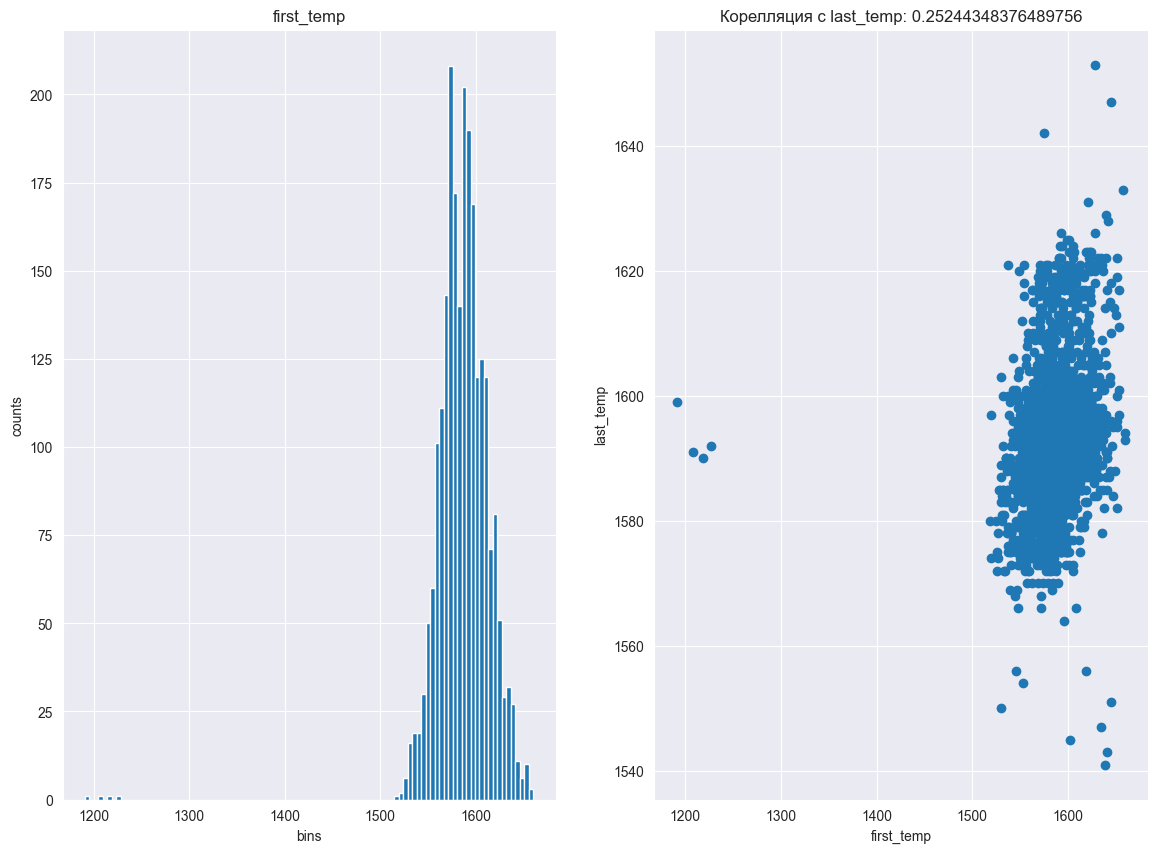

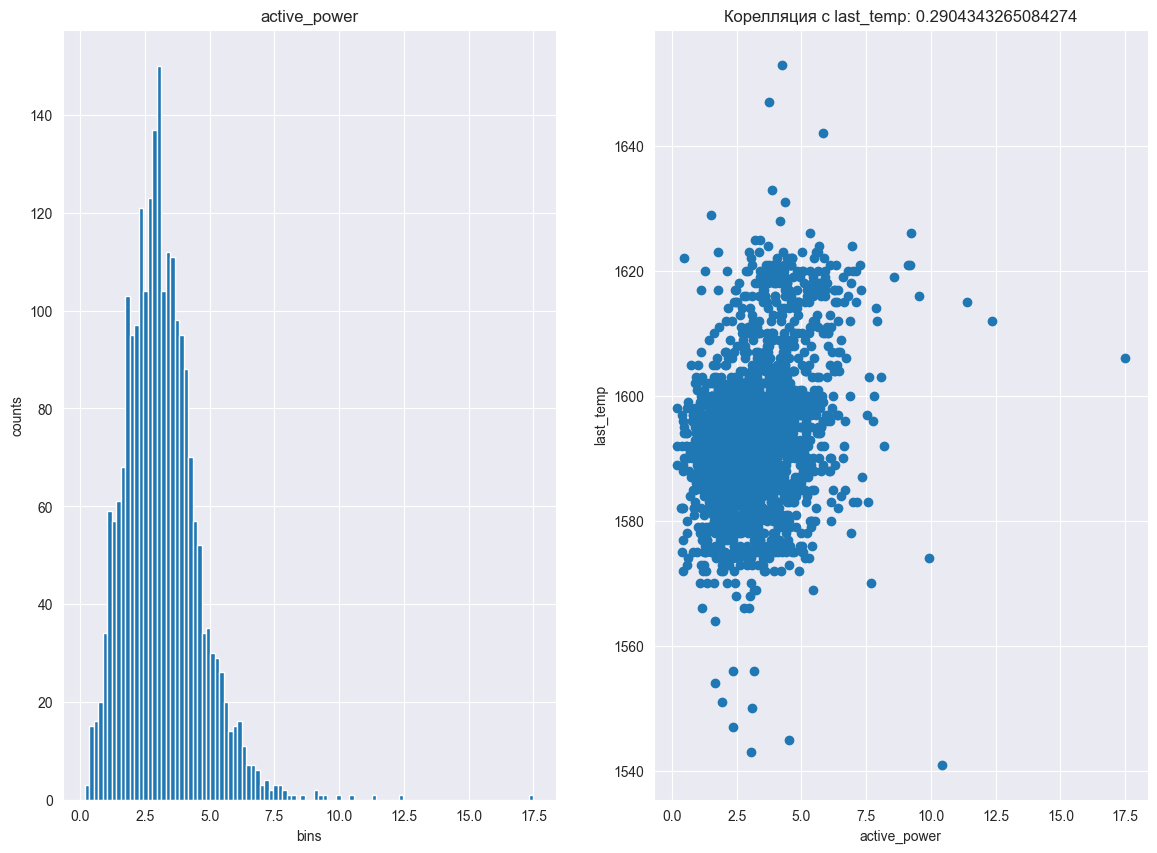

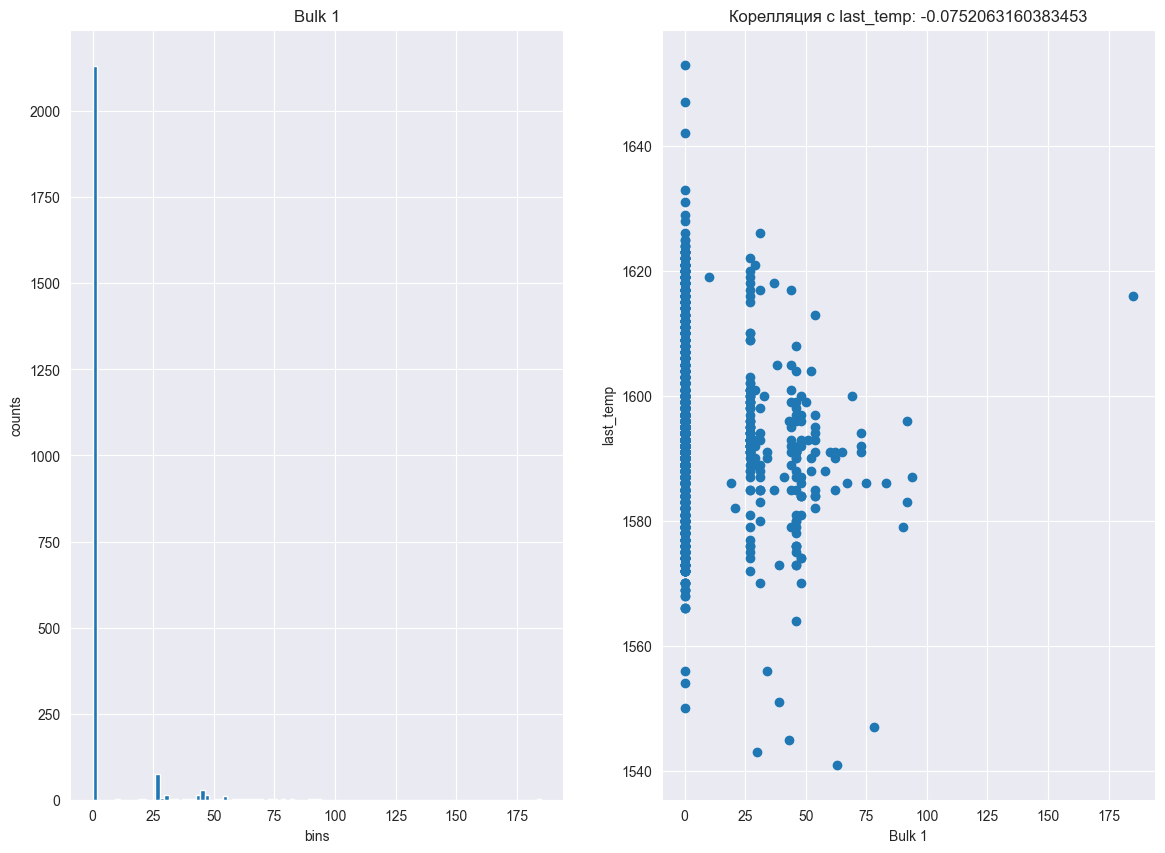

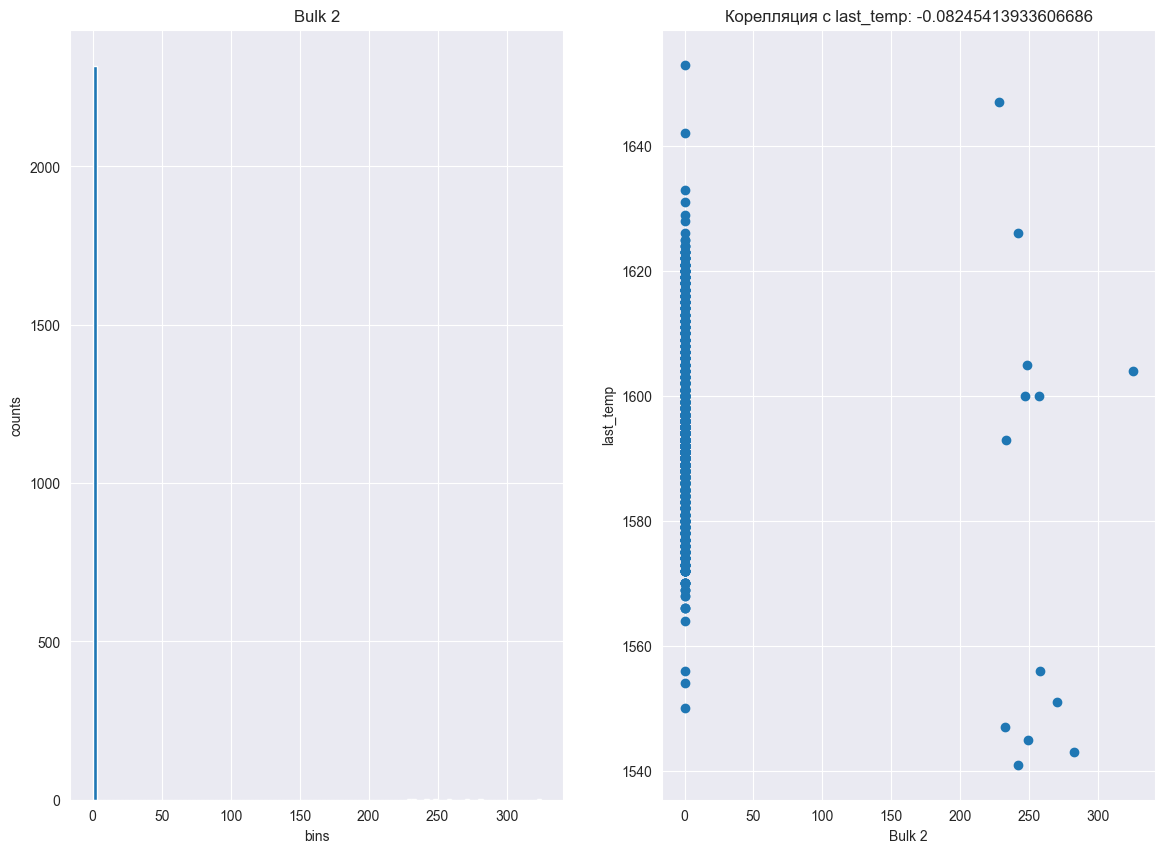

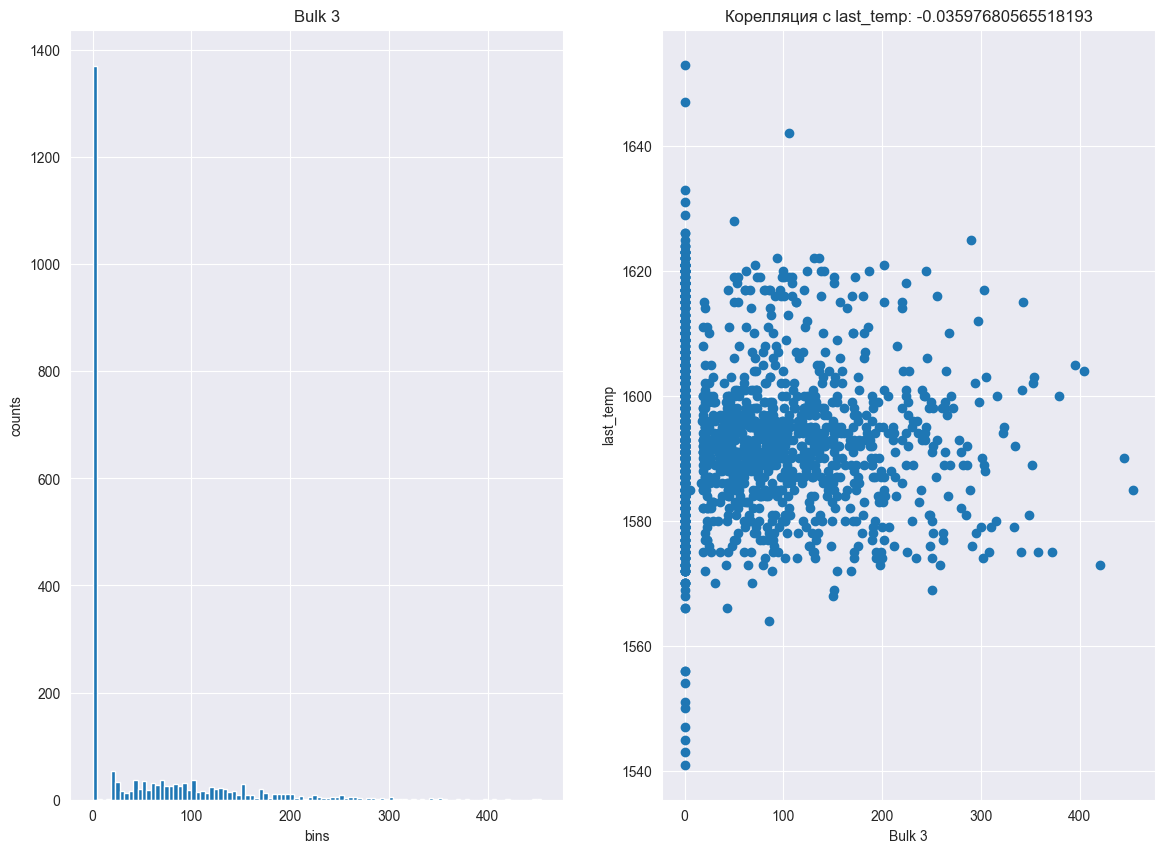

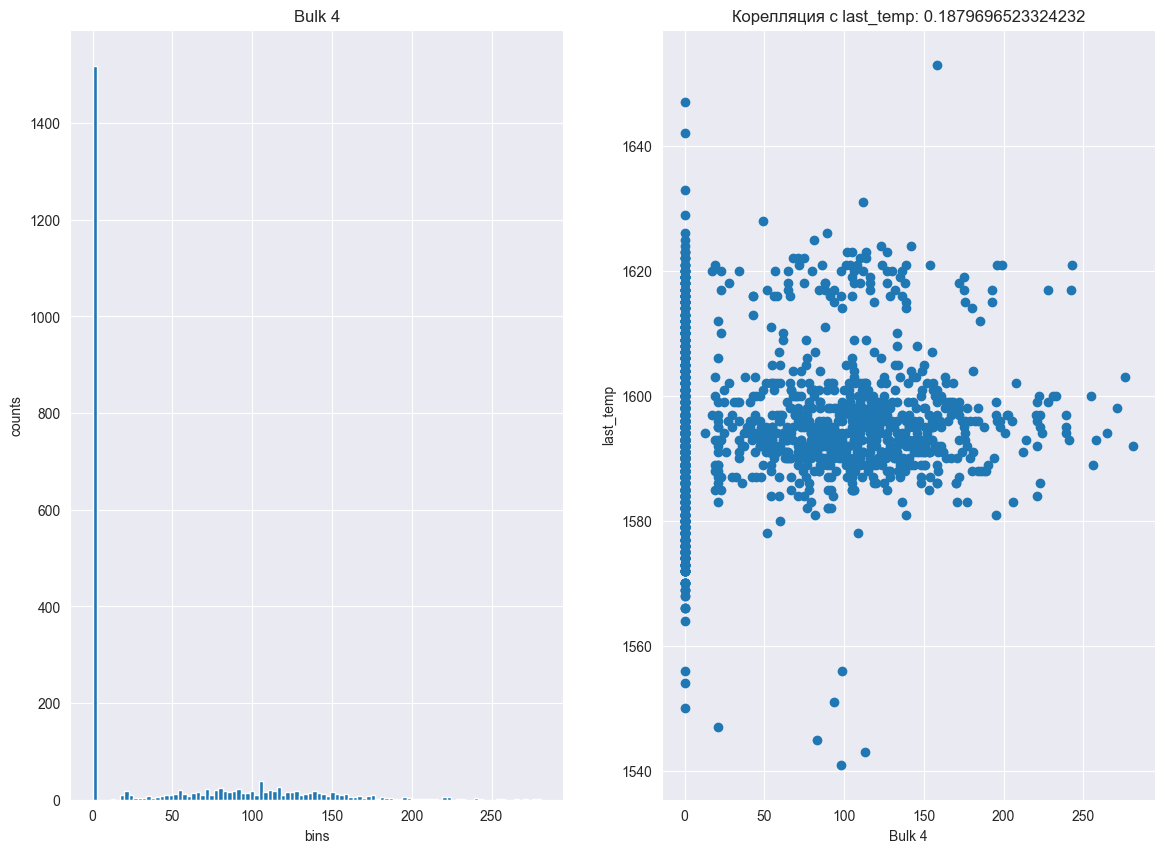

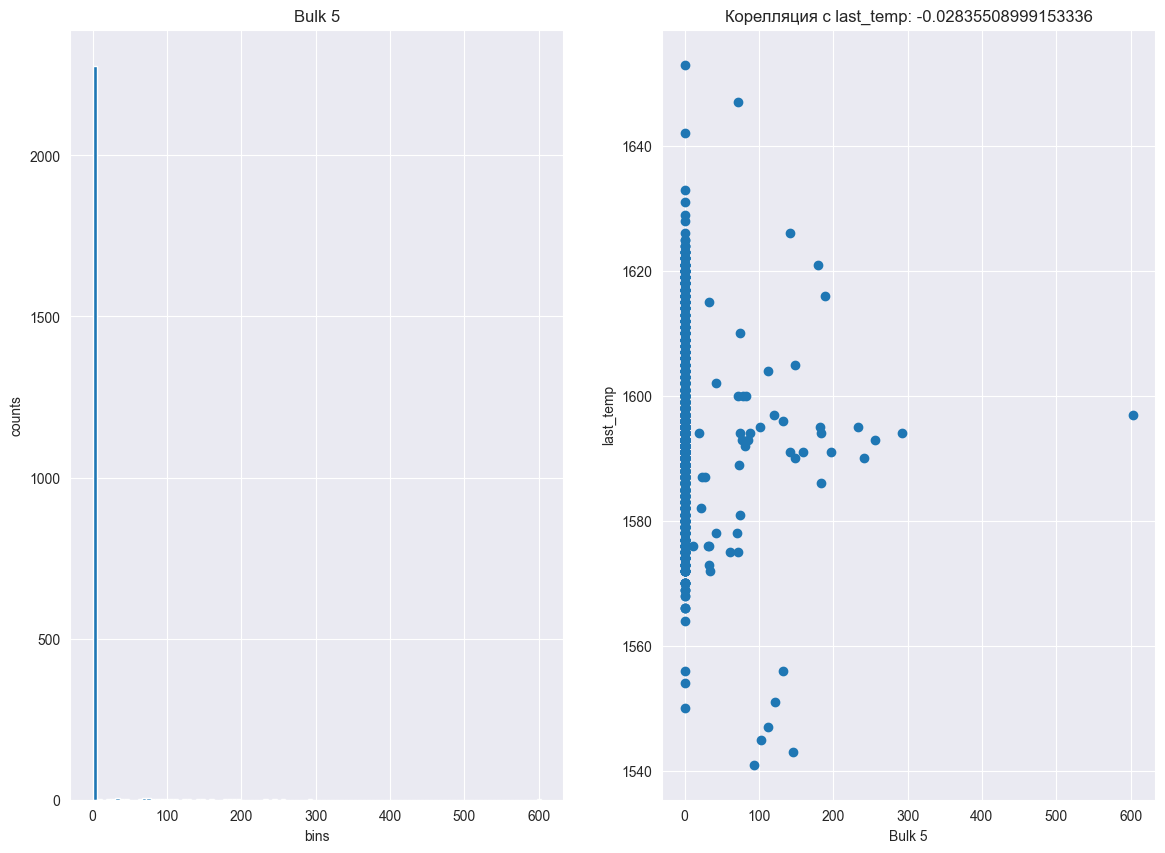

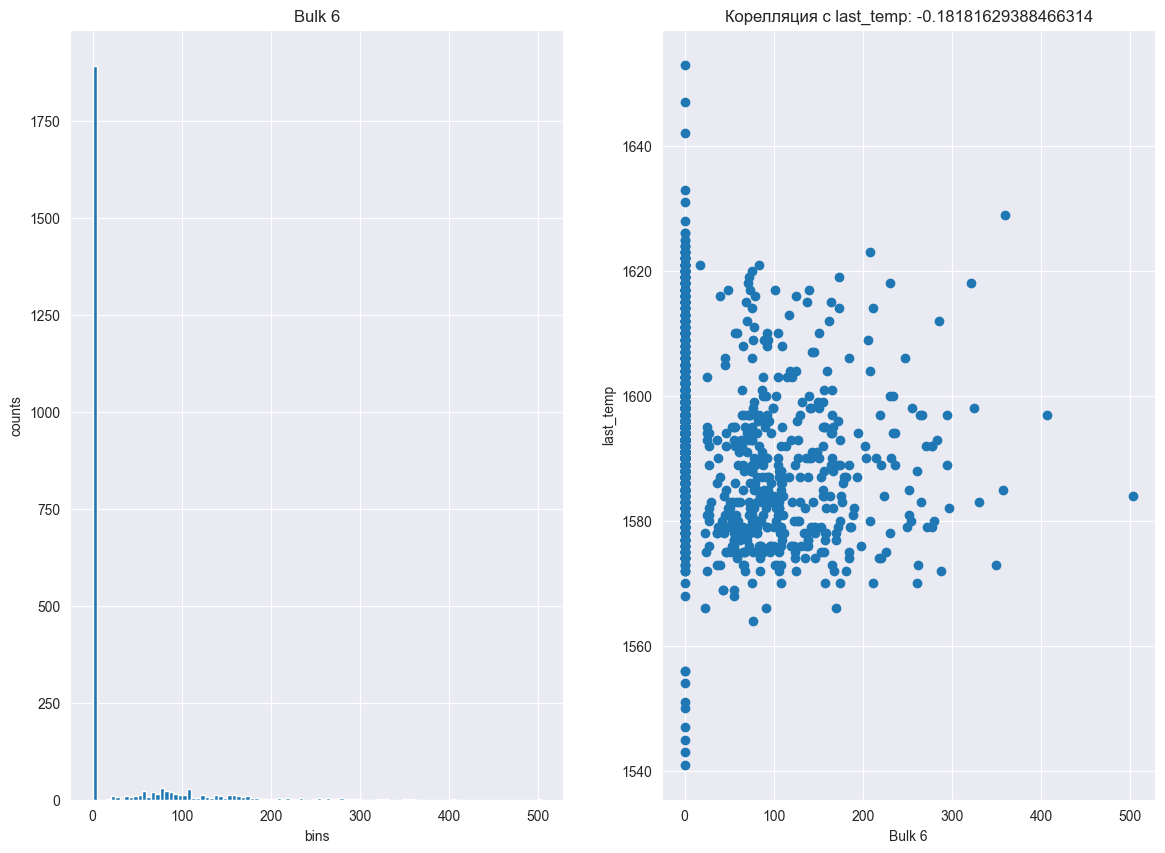

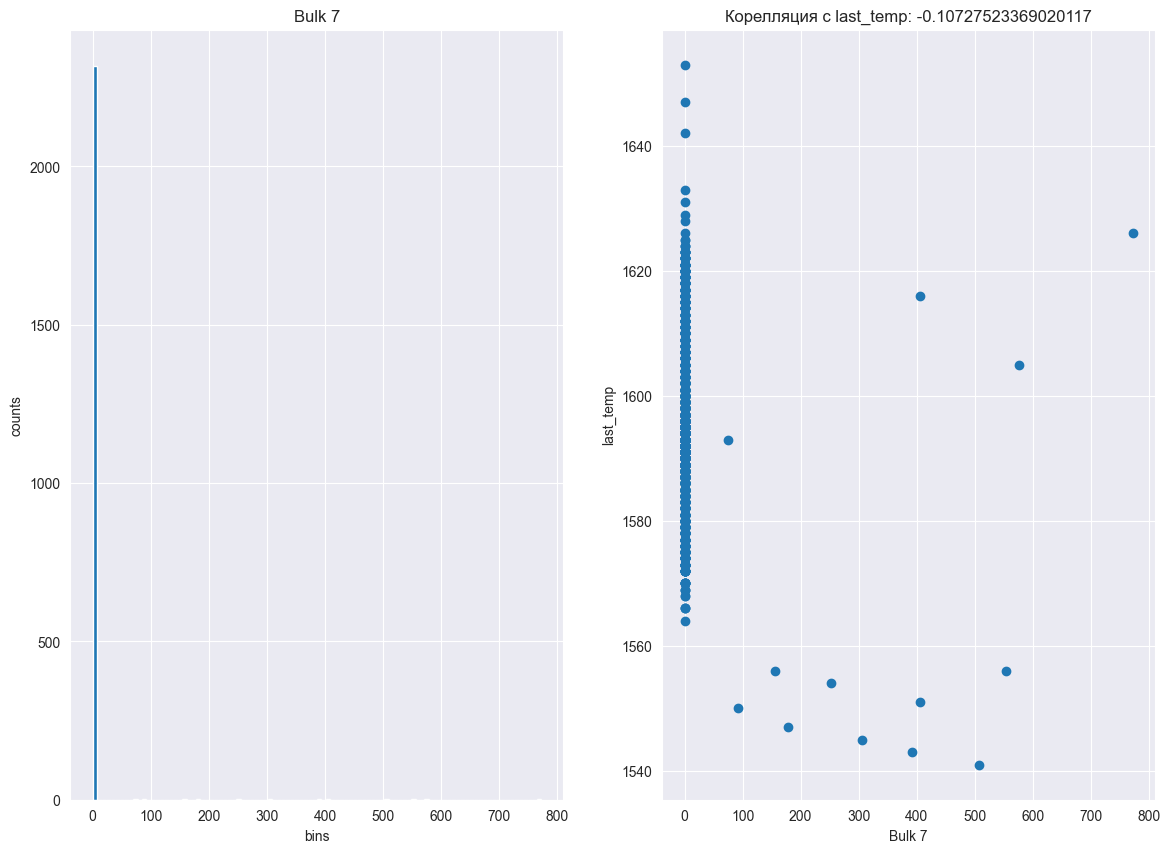

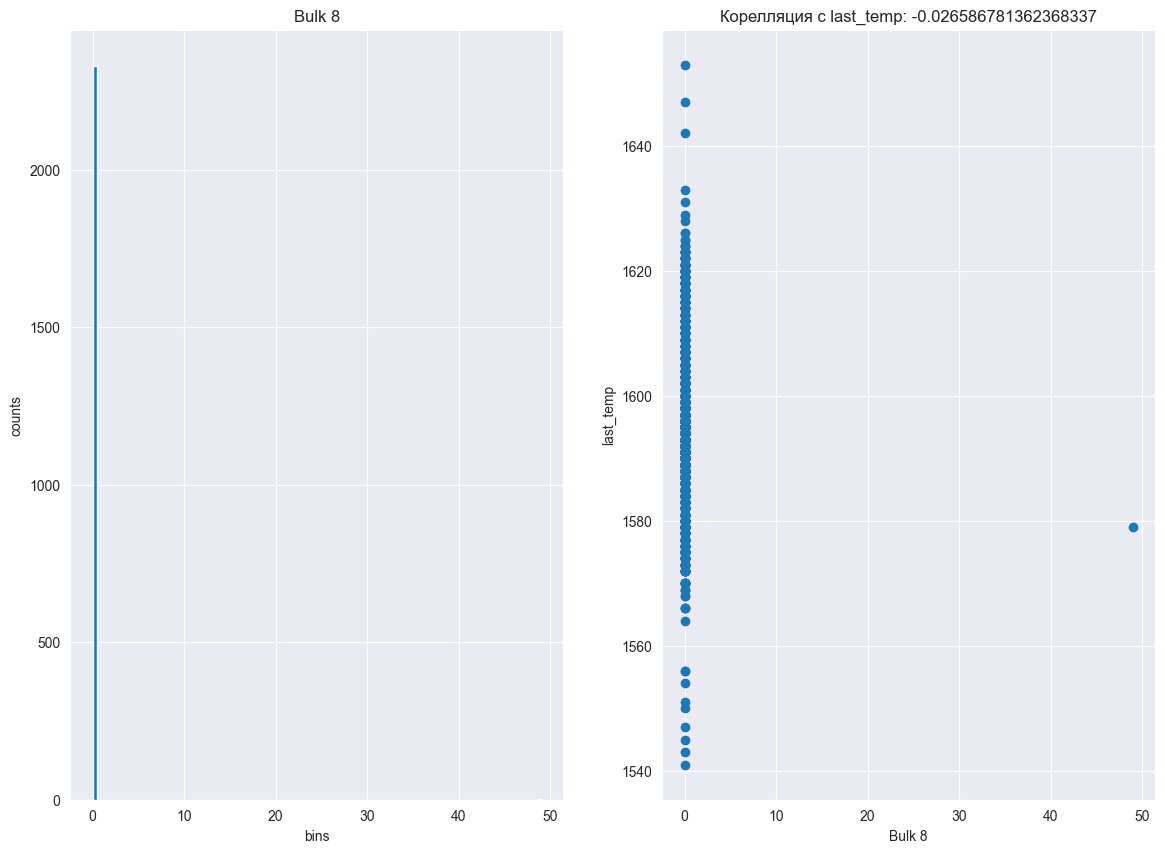

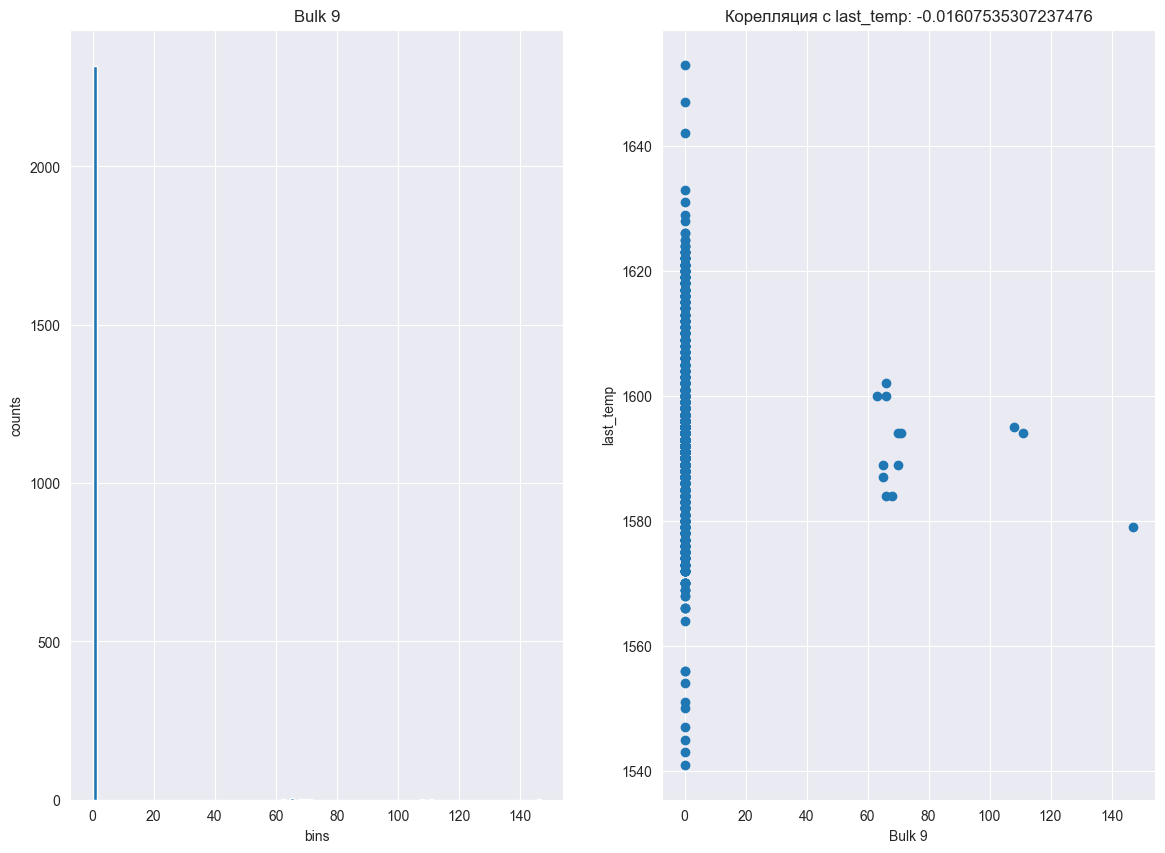

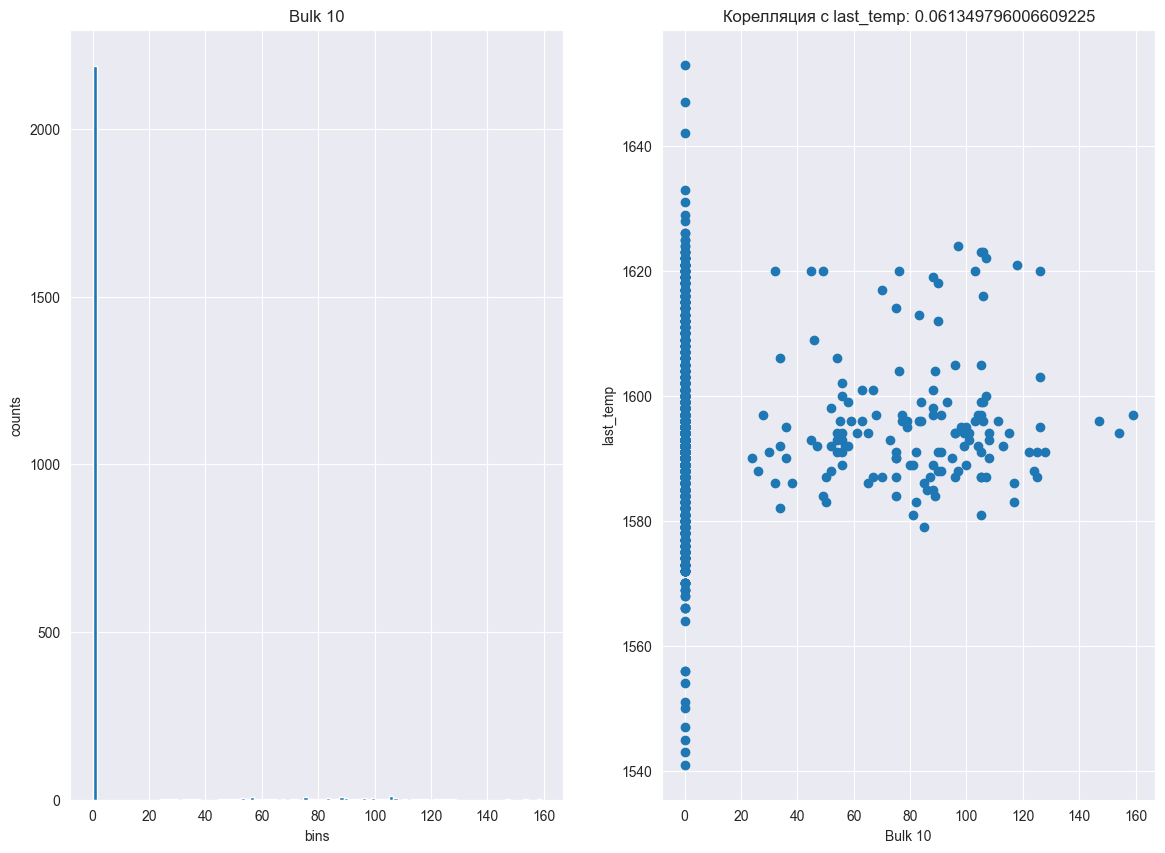

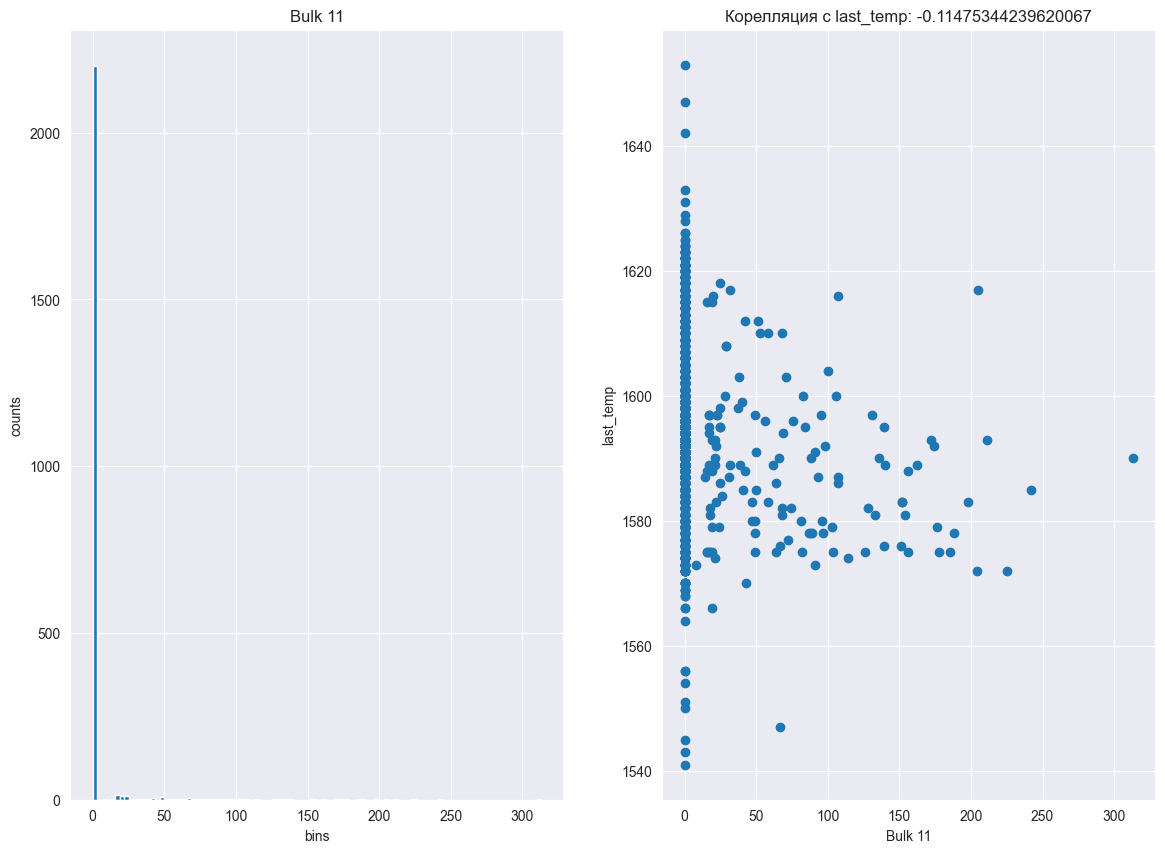

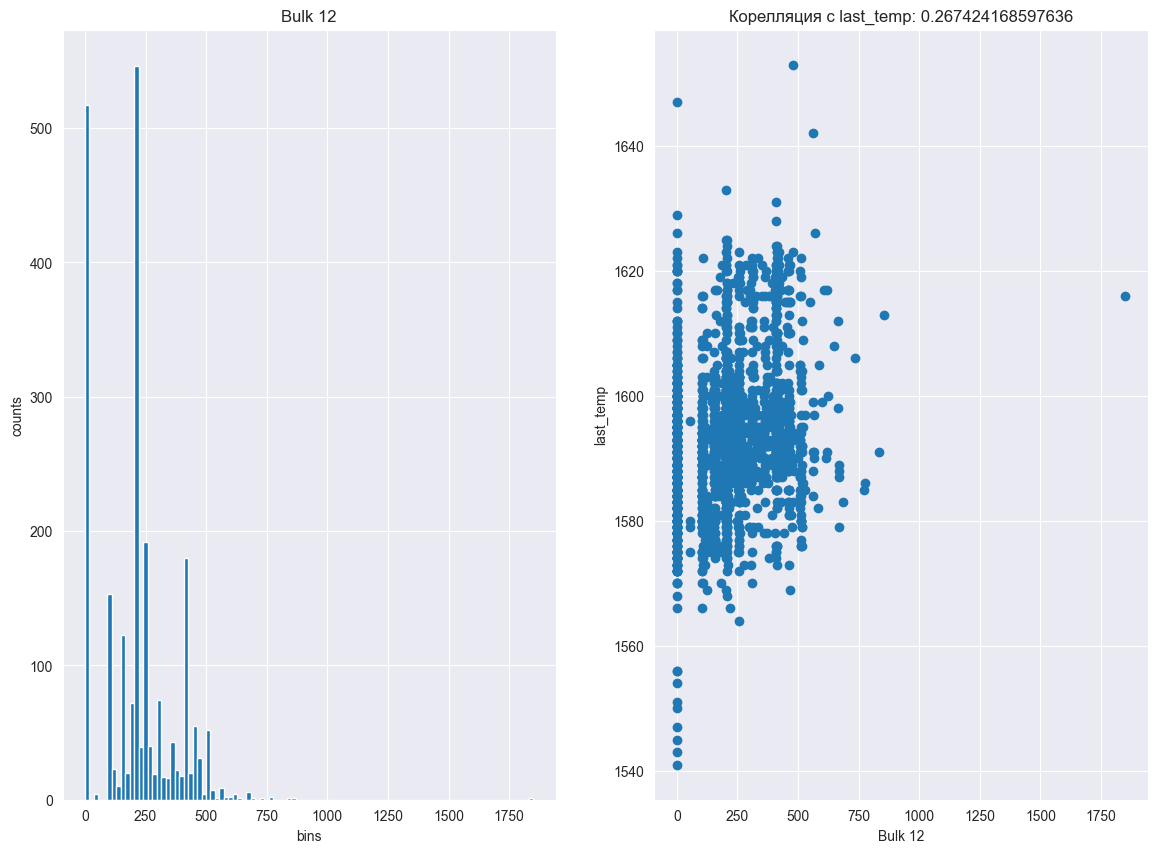

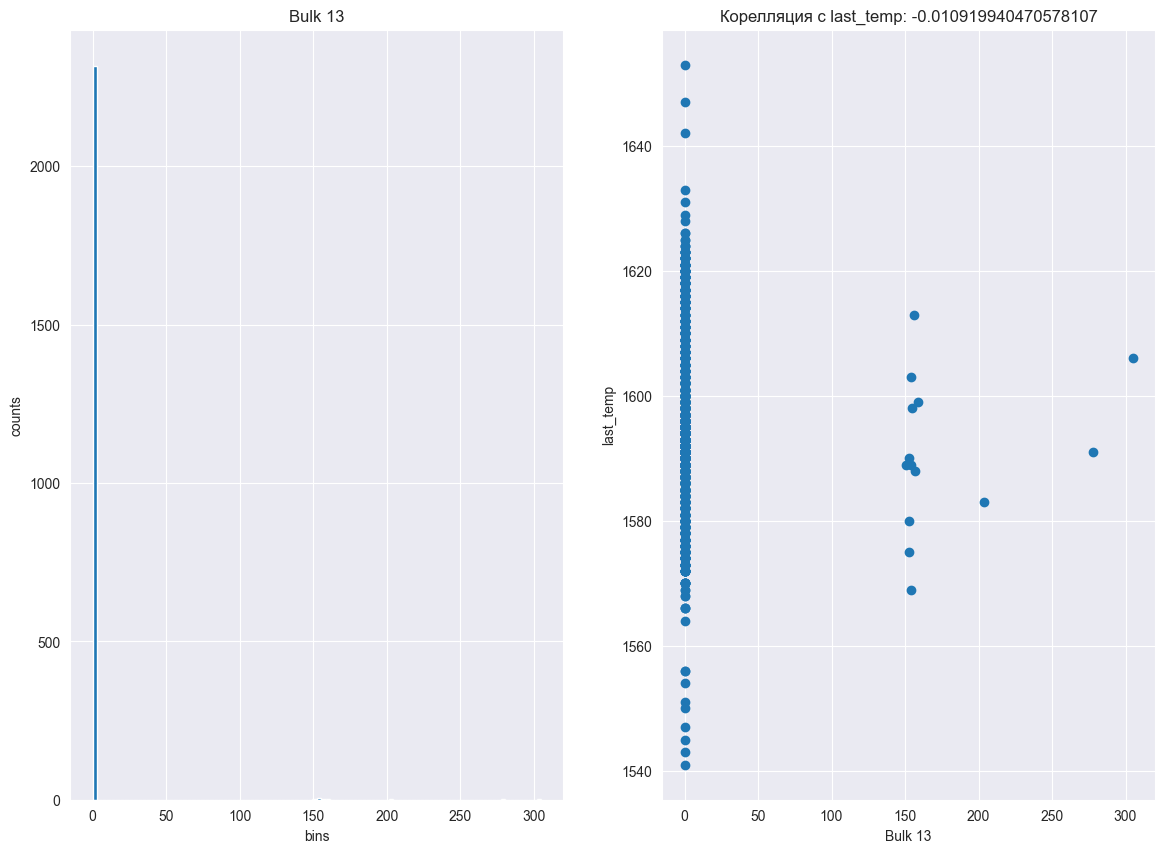

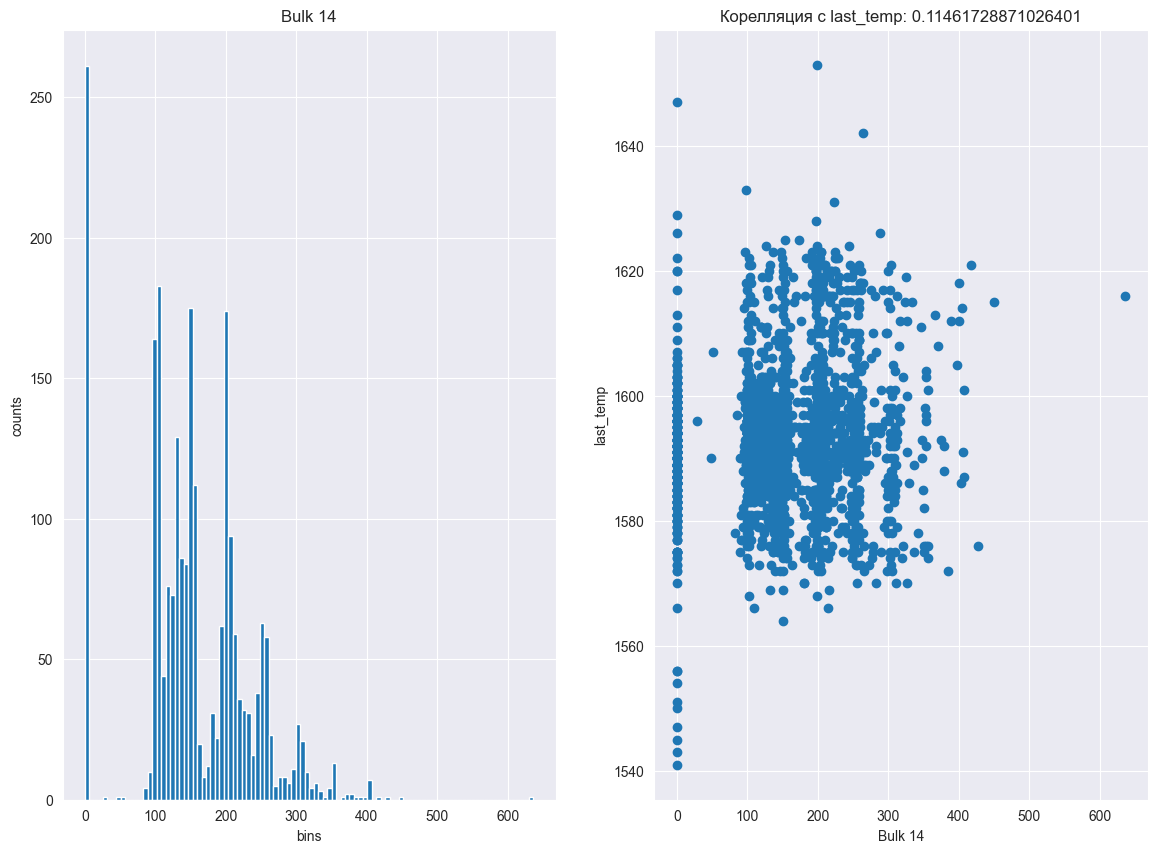

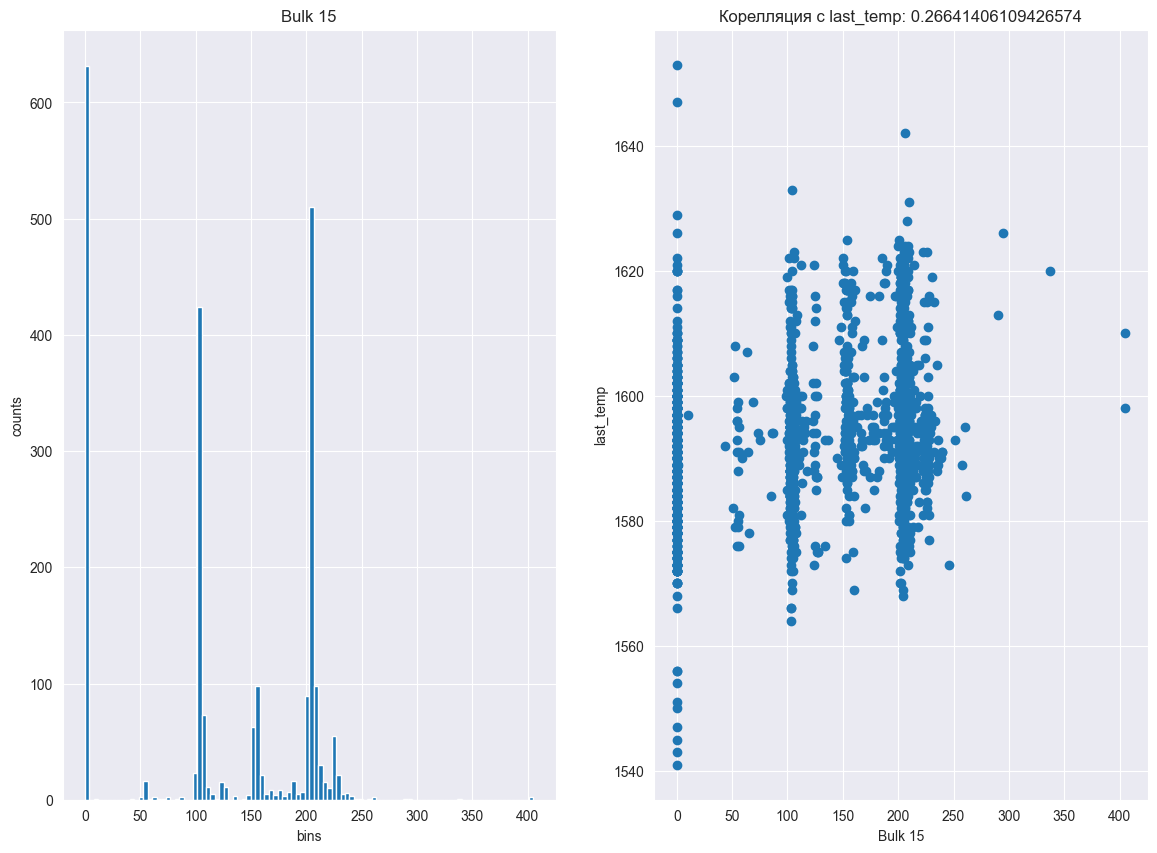

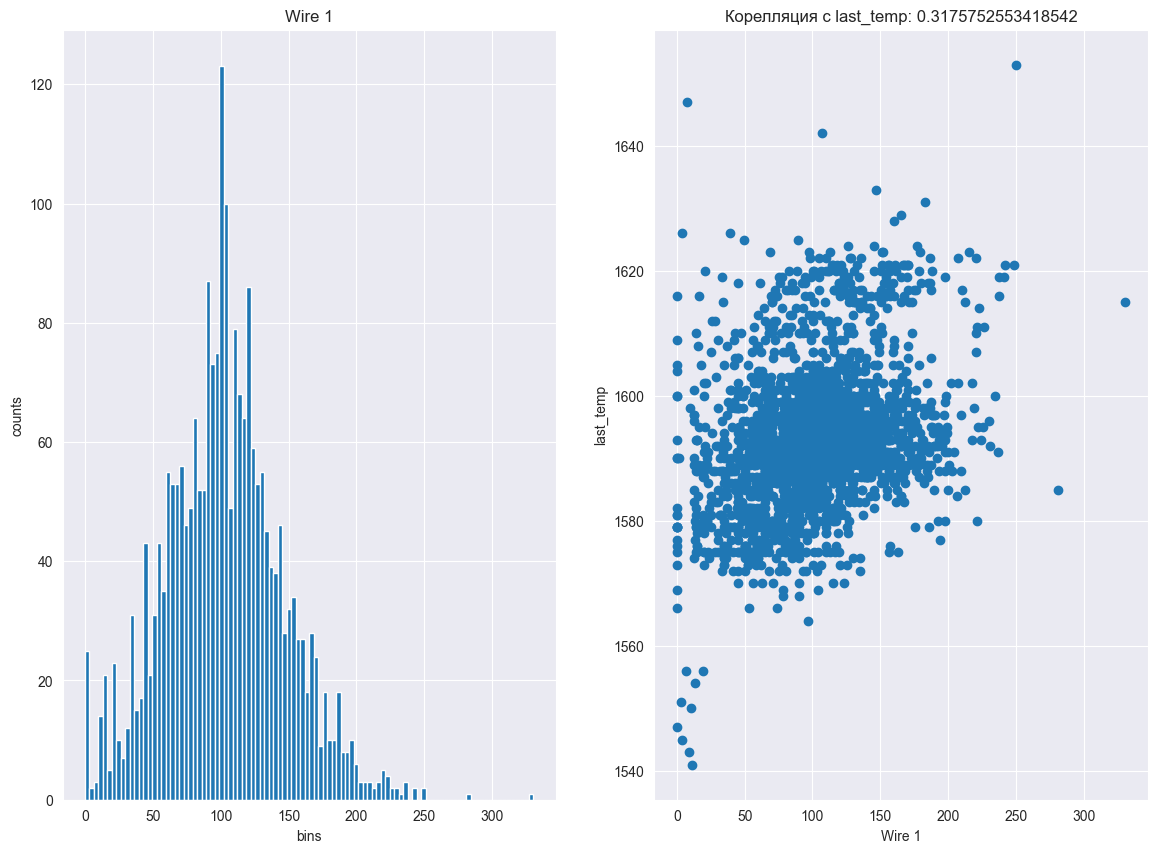

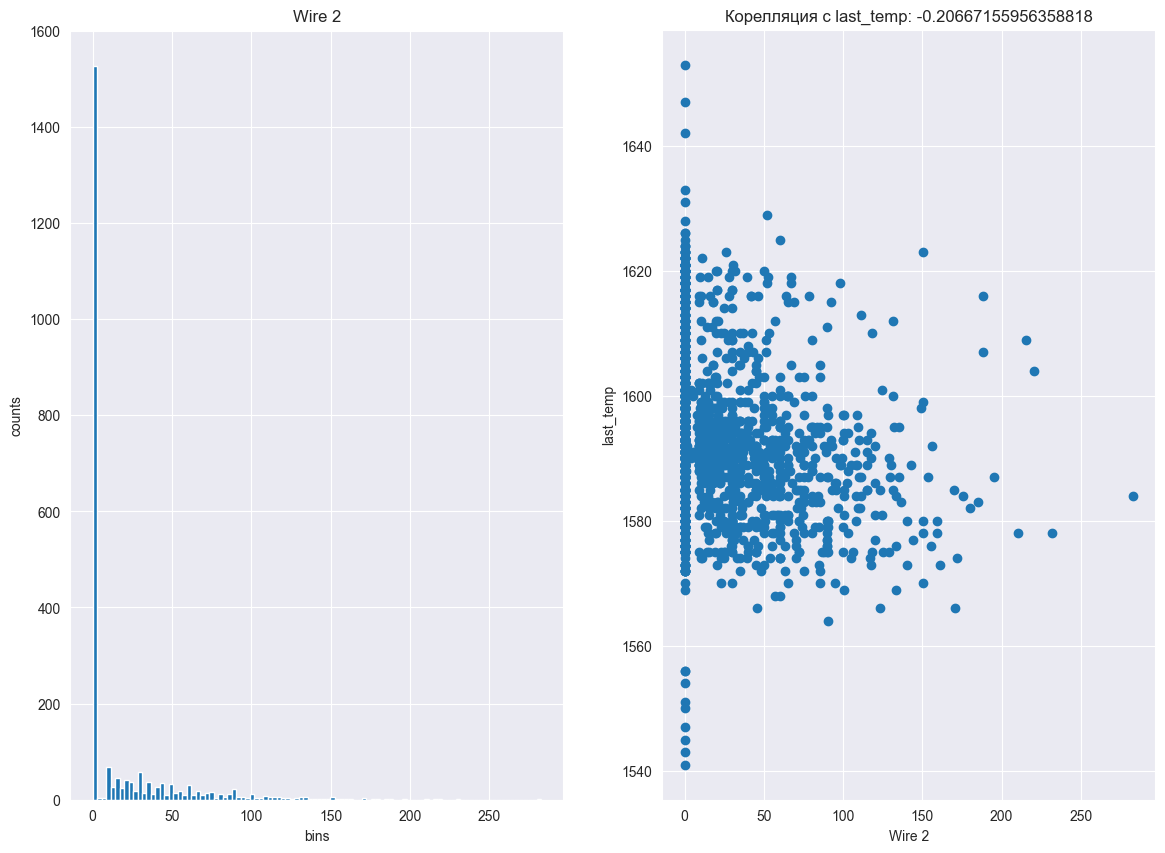

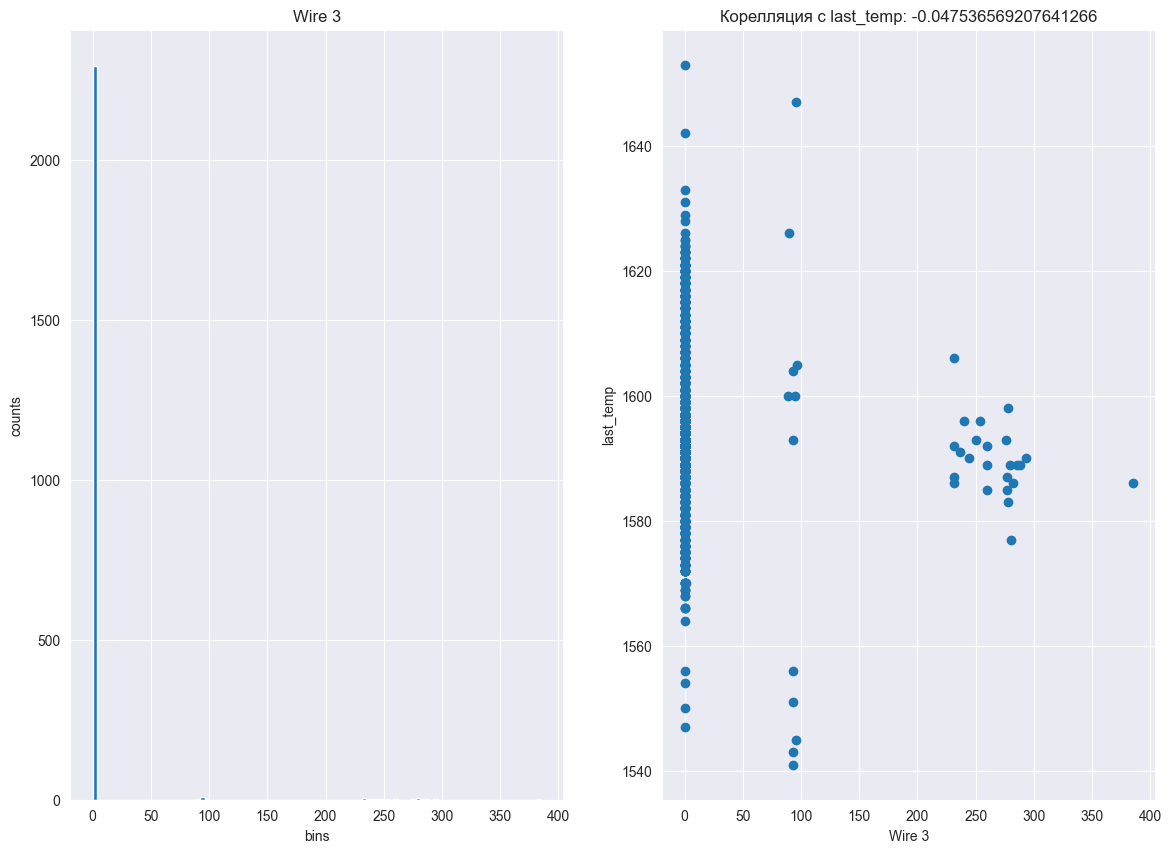

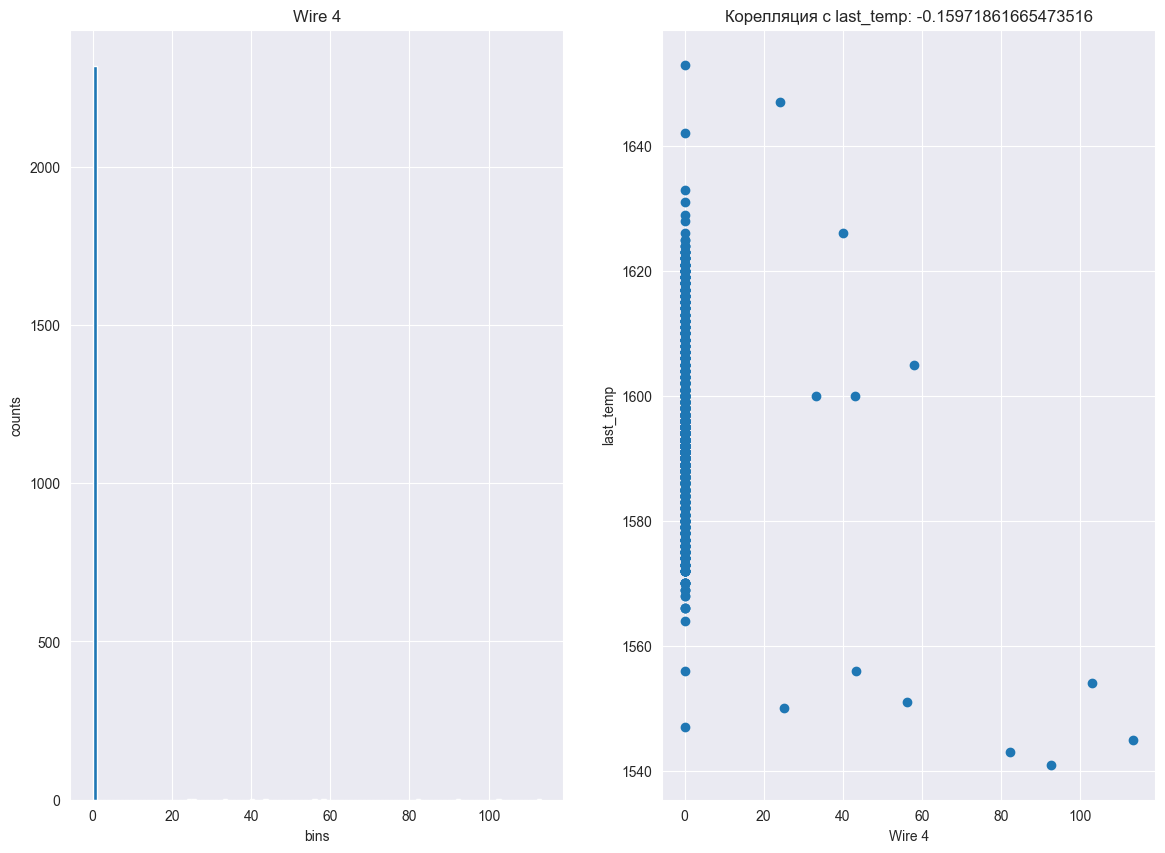

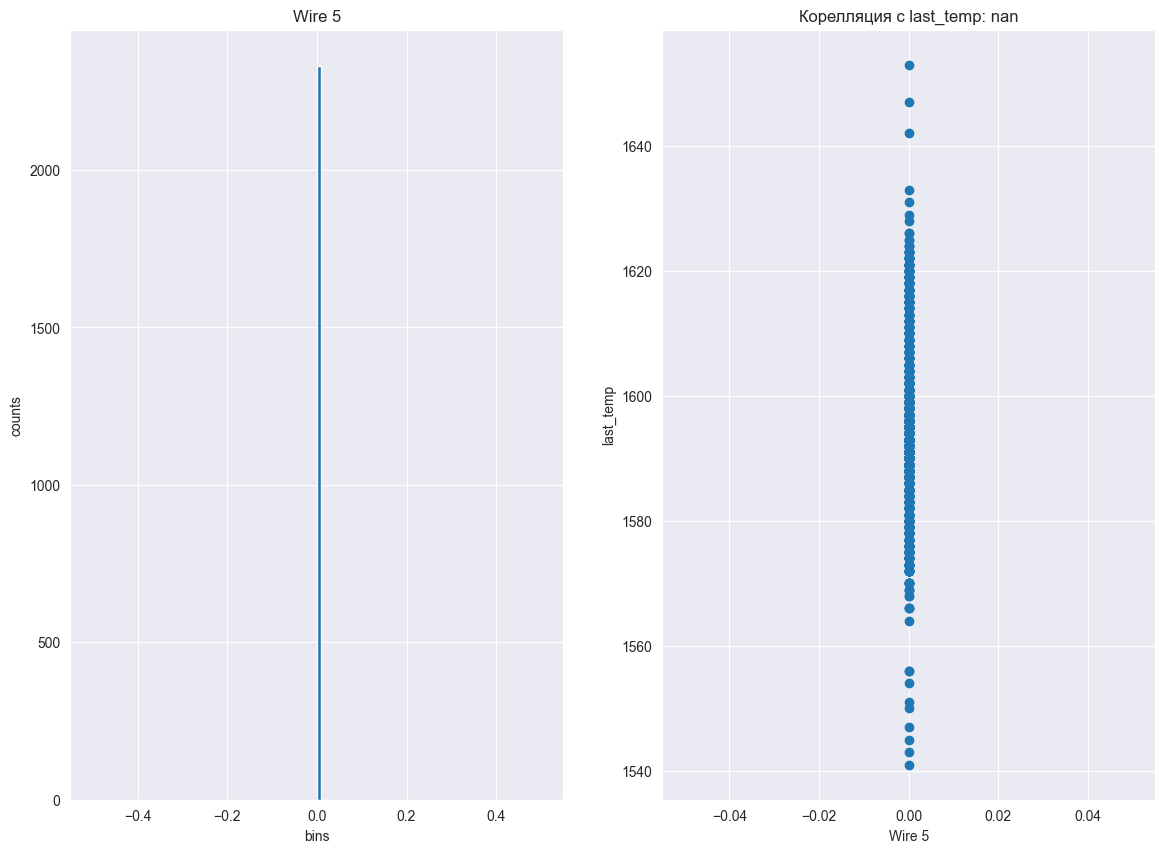

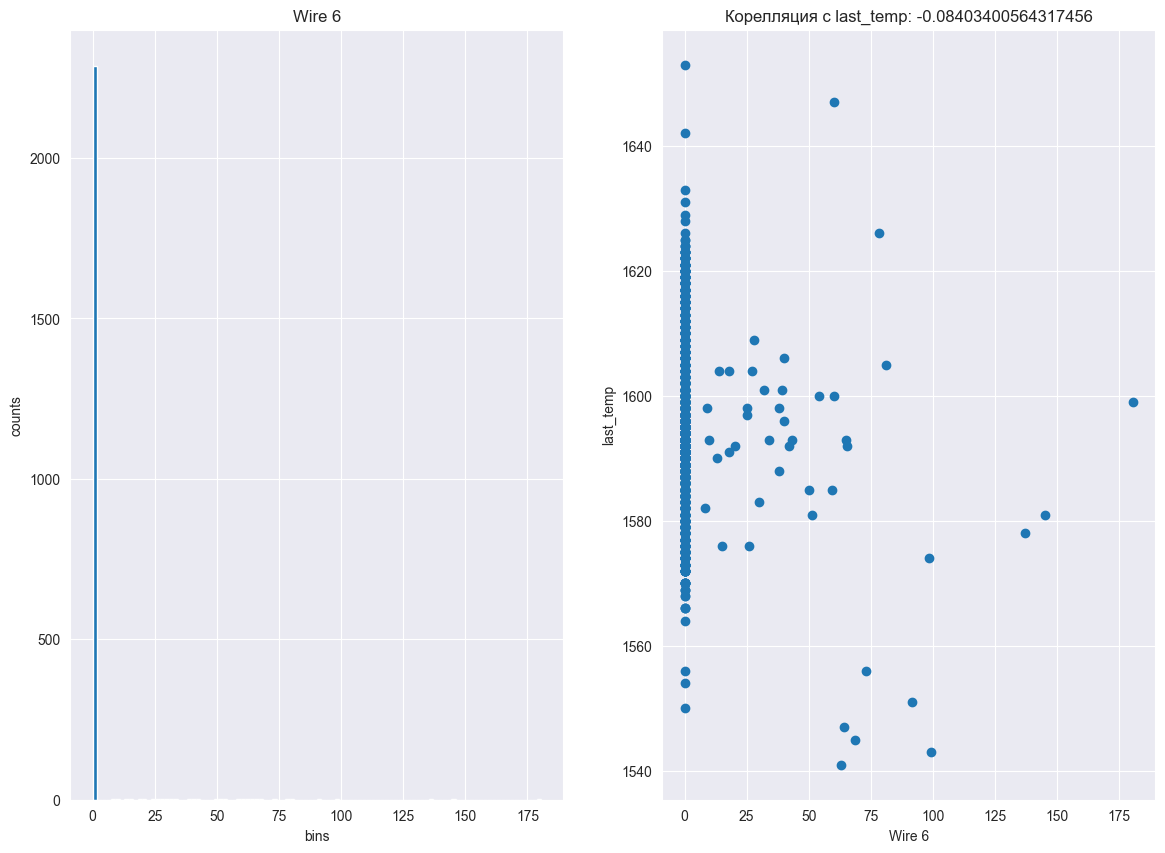

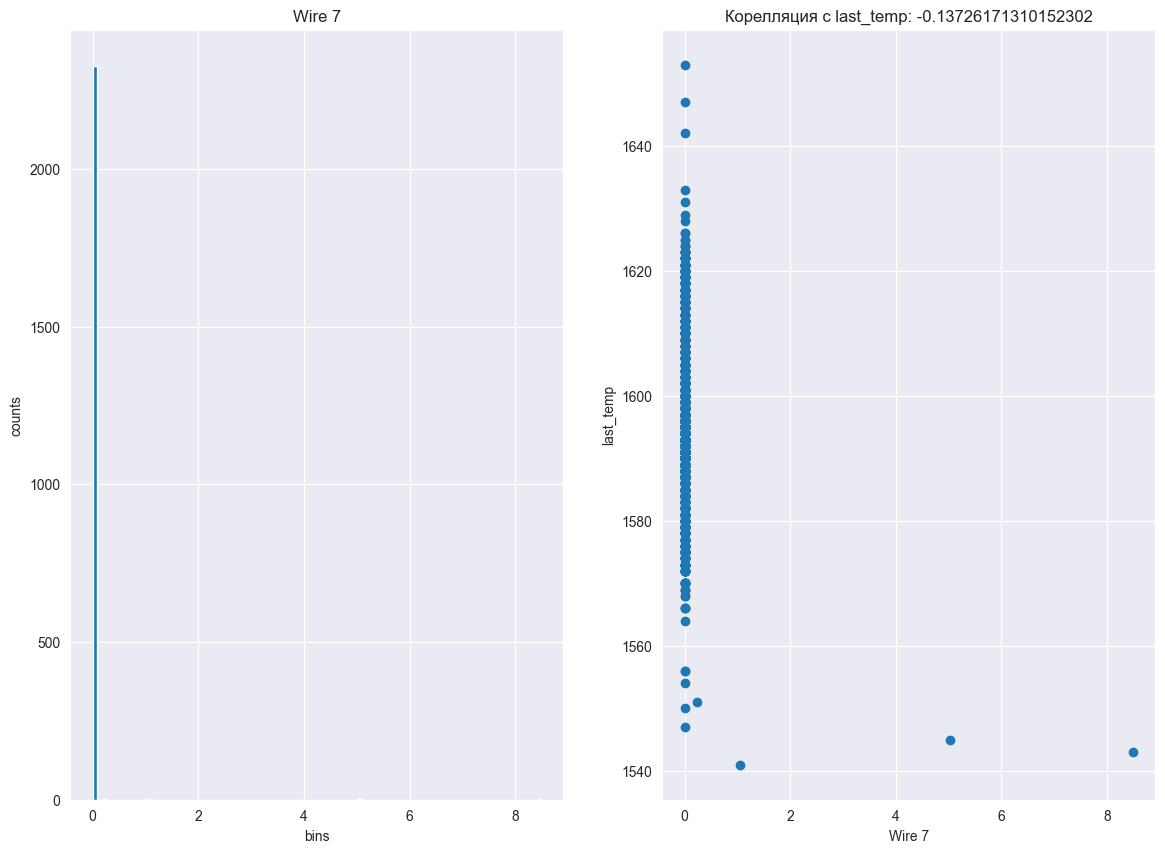

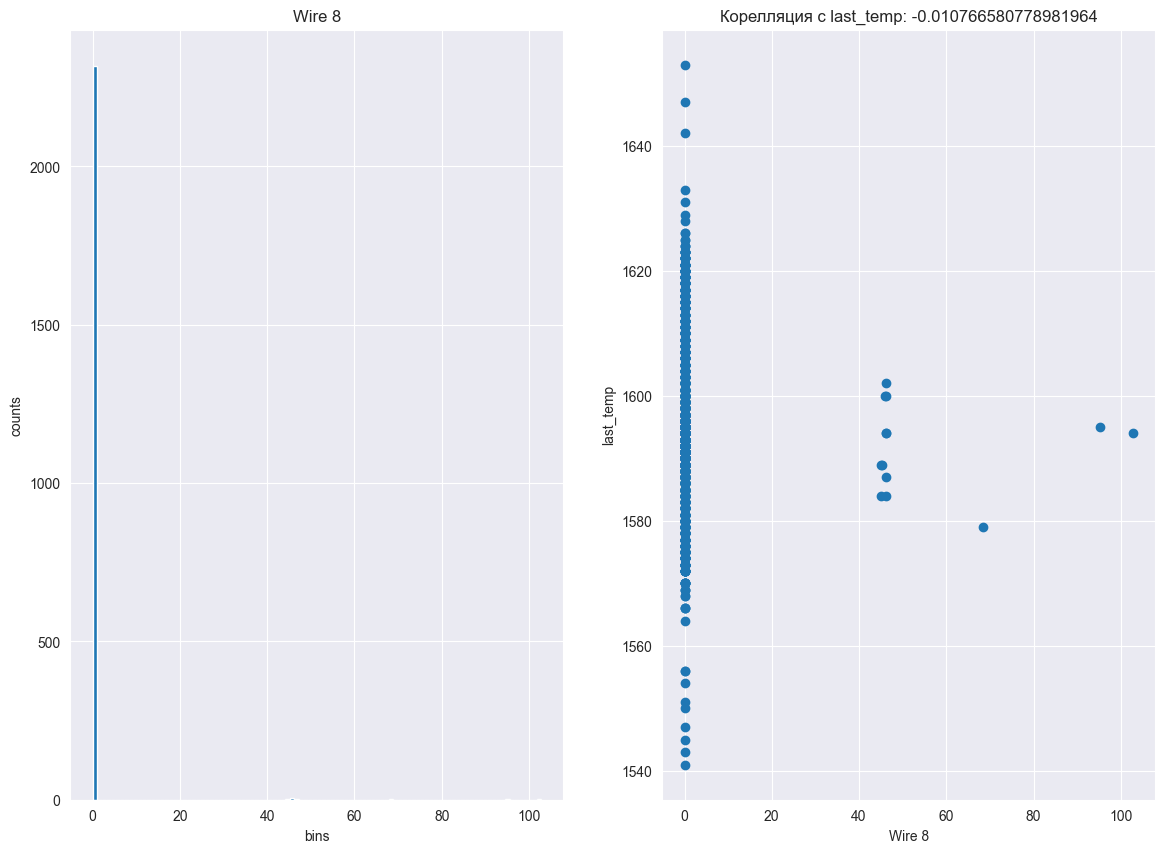

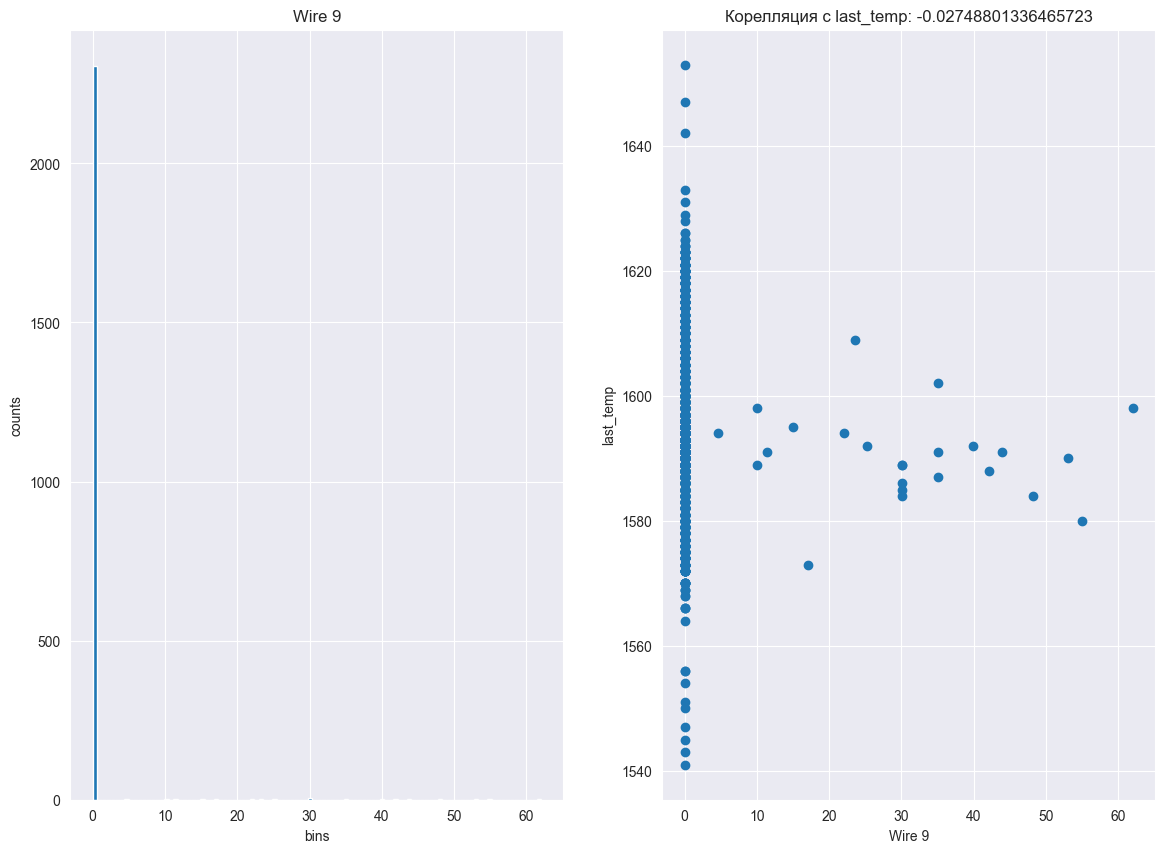

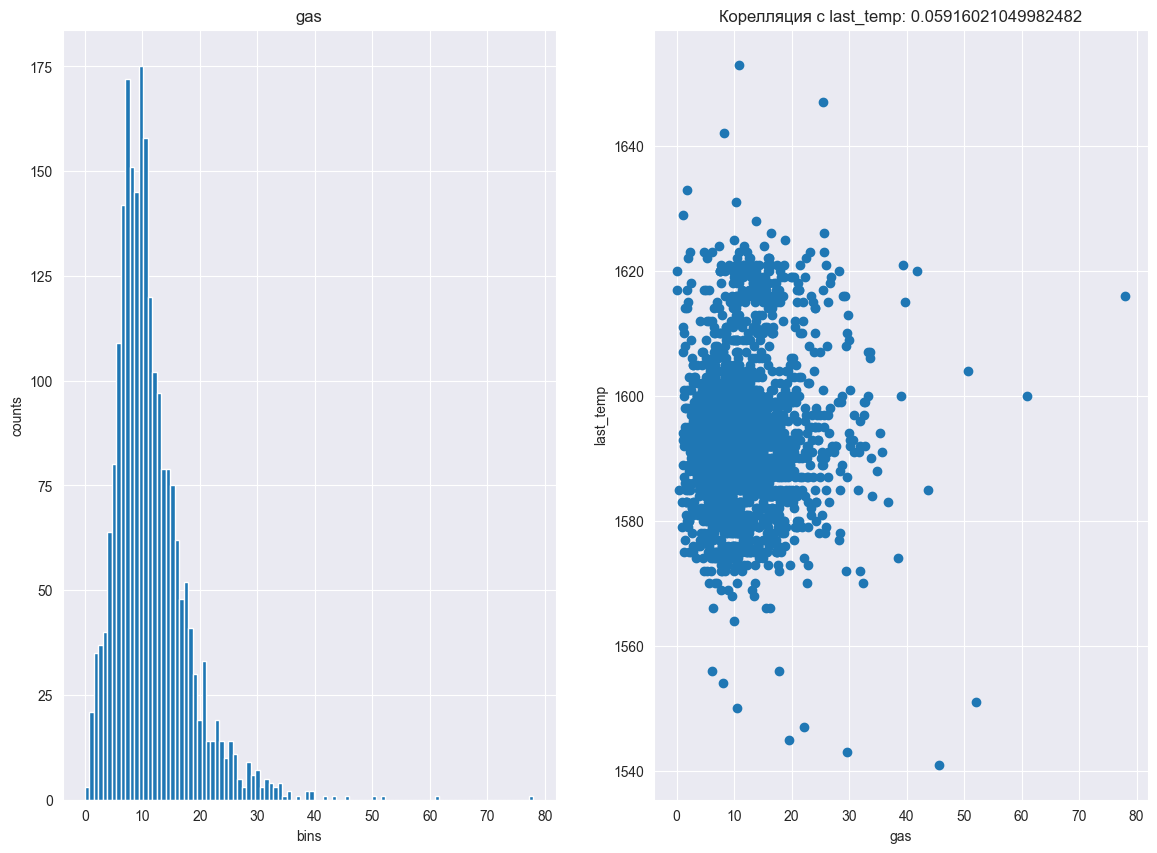

In [42]:
for column in data.columns.drop('last_temp'):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,10))
    
    ax1.hist(data[column], bins=100)
    ax1.grid(True)
    ax1.set_title(column)
    ax1.set_ylabel('counts')
    ax1.set_xlabel('bins')
    
    ax2.scatter(data[column], data['last_temp'])
    ax2.grid(True)
    ax2.set_title('Корелляция с last_temp: ' + str(data[column].corr(data['last_temp'])))
    ax2.set_ylabel('last_temp')
    ax2.set_xlabel(column)
    

<b>Комментарий: Некоторый анализ был уже проведен в подготовке данных, четкой зависимости на графиках не проследуется, особенно в некоторый местах нет вообще данных, какой то материал вообще не добавляли, какой то всего один раз. Некоторые данные показывали корреляцию около 0.3. Однако по вышеизложенны мыслям, я считаю, что именно эти признаки могут участвовать в формировании конечной температуры.
</b></font>

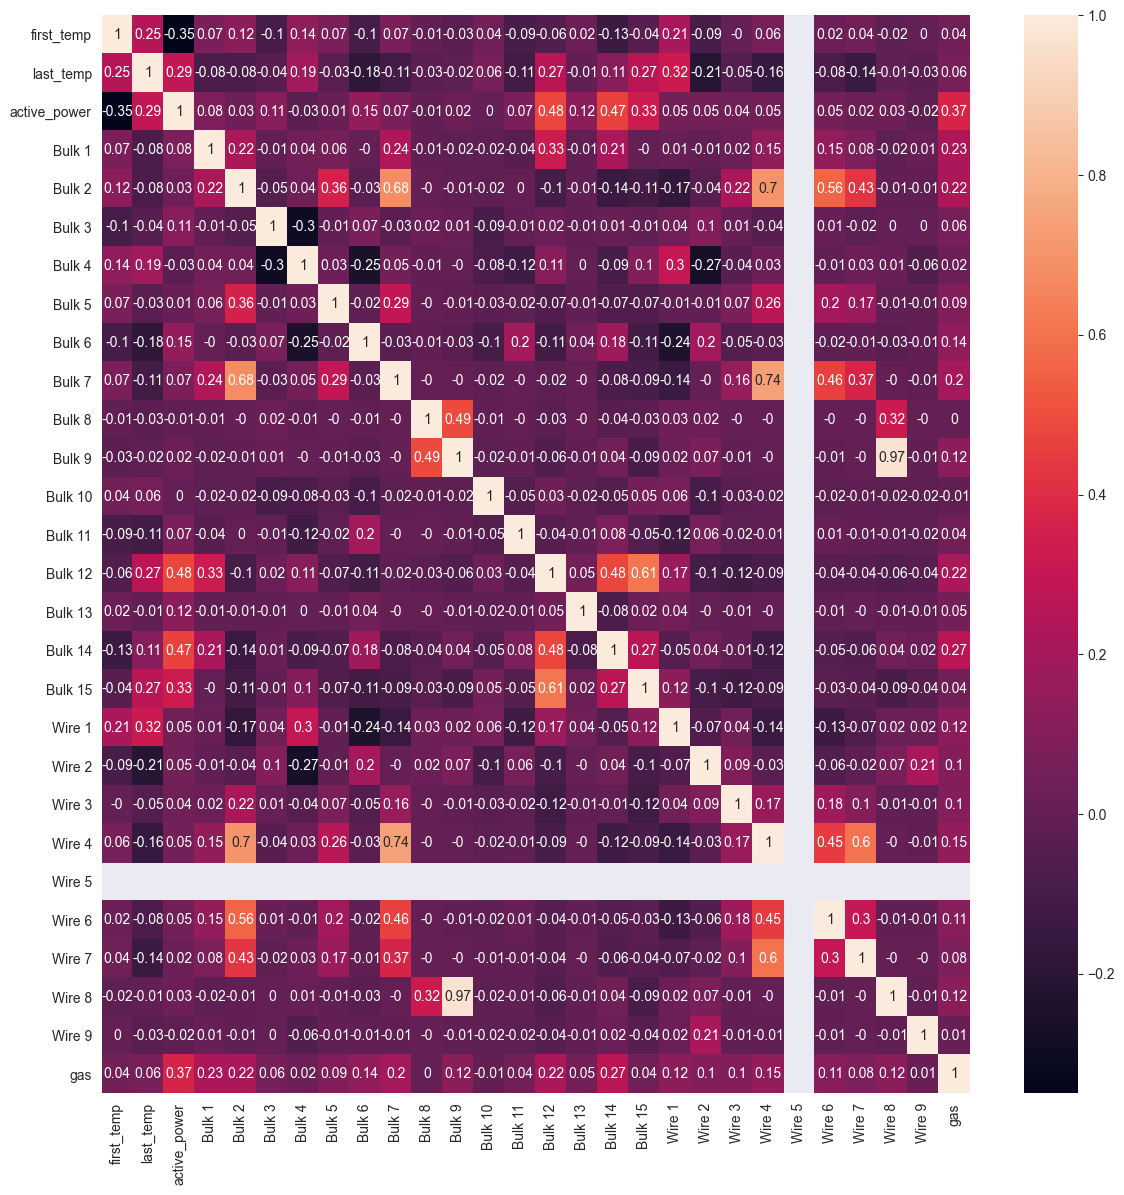

In [43]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(round(data.corr(),2), annot=True);

<b>Комментарий: В last_temp нет сильных корреляций, лишь пара около 0.3. Если брать корреляцию между признаками, то выделяются некоторые пересечения различных bulk и wire, особоенно поражает корелляция в 0.97 между bulk 9 и wire 8</b></font>

## Обучение моделей

<b>Комментарий: У нас нет категориальный признаков, поэтому ограничимся лишь масштабированием признаков.</b></font>

In [44]:
scaler = StandardScaler()
result_list = []

<b>Комментарий: По условиям необходимо добиться показателя метрики MAE меньше 6.8. Рассмотрим различные регрессионные модели:</b></font>

In [45]:
%%time
model_linear = LinearRegression()
pipe_linear = Pipeline(steps=[("scaler", scaler), ("linear", model_linear)])
scores_linear = cross_val_score(pipe_linear, features_train, target_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print('LinearRegression MAE score:', abs(scores_linear.mean()))

result_list.append({
    'model': 'Linear',
    'MAE score':  abs(scores_linear.mean()),
    'best_params': '----'
});

LinearRegression MAE score: 6.070123931475523
CPU times: total: 78.1 ms
Wall time: 3.12 s


In [46]:
%%time
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose = False)

param_catboost = {'catboost__depth': [4,5,6,7,8,9],
                  'catboost__learning_rate': [0.01,0.05,0.1],
                  'catboost__iterations': [200,250,300,350]
                 }
pipe_catboost = Pipeline(steps=[("scaler", scaler), ("catboost", model_catboost)])
grid_catboost = GridSearchCV(pipe_catboost, param_grid = param_catboost, 
                             cv=5, scoring = "neg_mean_absolute_error", n_jobs=-1)
grid_catboost.fit(features_train, target_train);

result_list.append({
    'model': 'CatBoost',
    'MAE score': abs(grid_catboost.best_score_),
    'best_params': grid_catboost.best_params_
});

CPU times: total: 10.2 s
Wall time: 4min 3s


In [47]:
print("CatBoostRegressor GridSearchCV MAE:", abs(grid_catboost.best_score_))
print("Параметры модели CatBoostRegressor:", grid_catboost.best_params_)

CatBoostRegressor GridSearchCV MAE: 5.805171095998662
Параметры модели CatBoostRegressor: {'catboost__depth': 7, 'catboost__iterations': 300, 'catboost__learning_rate': 0.05}


In [48]:
%%time
model_tree = DecisionTreeRegressor(random_state = RANDOM_STATE)

param_tree = {'max_depth': range (1,10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (1,8) }

grid_tree = GridSearchCV(model_tree, param_grid = param_tree, 
                         cv=5, scoring = "neg_mean_absolute_error", n_jobs=-1)
grid_tree.fit(features_train, target_train);

result_list.append({
    'model': 'DecisionTree',
    'MAE score': abs(grid_tree.best_score_),
    'best_params': grid_tree.best_params_
});

CPU times: total: 1.86 s
Wall time: 3.79 s


In [49]:
print("DecisionTree GridSearchCV MAE:", abs(grid_tree.best_score_))
print("Параметры модели DecisionTreeRegressor:", grid_tree.best_params_)

DecisionTree GridSearchCV MAE: 6.85232343637192
Параметры модели DecisionTreeRegressor: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [50]:
%%time
model_lgb = lgb.LGBMRegressor(metric = 'rmse',random_state=RANDOM_STATE)

param_lgb = {'max_depth': [3,4,5,6],
             'learning_rate': [0.07, 0.08, 0.09, 0.1],
             'n_estimators': [70, 80, 90, 100]}

grid_lgb = GridSearchCV(model_lgb, param_grid = param_lgb, 
                        cv=5, scoring = "neg_mean_absolute_error", n_jobs=-1)
grid_lgb.fit(features_train, target_train);

result_list.append({
    'model': 'LGBMRegressor',
    'MAE score': abs(grid_lgb.best_score_),
    'best_params': grid_lgb.best_params_
});

CPU times: total: 1.52 s
Wall time: 3.21 s


In [51]:
print("LGBMRegressor GridSearchCV MAE:", abs(grid_lgb.best_score_))
print("Параметры модели LGBMRegressor:", grid_lgb.best_params_)

LGBMRegressor GridSearchCV MAE: 5.8963706981691475
Параметры модели LGBMRegressor: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 100}


In [52]:
%%time 
model_forest = RandomForestRegressor(random_state = RANDOM_STATE)

parametrs_forest = {'n_estimators': range (100, 501, 100),
                    'max_depth': range (5, 12)}


grid_forest = GridSearchCV(model_forest, param_grid = parametrs_forest, 
                           cv=5, scoring = "neg_mean_absolute_error", n_jobs=-1)
grid_forest.fit(features_train, target_train);

result_list.append({
    'model': 'RandomForest',
    'MAE score': abs(grid_forest.best_score_),
    'best_params': grid_forest.best_params_
});

CPU times: total: 2.72 s
Wall time: 51.8 s


In [53]:
print("RandomForestRegressor GridSearchCV MAE:", abs(grid_forest.best_score_))
print("Параметры модели RandomForestRegressor:", grid_forest.best_params_)

RandomForestRegressor GridSearchCV MAE: 5.99742077063226
Параметры модели RandomForestRegressor: {'max_depth': 10, 'n_estimators': 300}


<b>Комментарий: Все модели кроме DecisionTreeRegressor прошли необходимый порог в 6.8, лучший показатель на кросс-валидации у CatBoostRegressor, однако она 2 втором месте по длительности обучения. Одна из самых успешных и приемлемая по скорости обучения - LGBMRegressor. Так как условий по скорости обучений на стоит, я бы предпочел выбрать CatBoost как лучшую модель, тем более 3 минуты обучения не так много.</b></font>

<b>Комментарий студента: Реализация автоматизированного обучения </b></font>

In [54]:
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("model", LinearRegression())])

params = [
    {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose = False)],
        'model__depth': [4,5,6,7,8,9],
        'model__learning_rate': [0.01,0.05,0.1],
        'model__iterations': [200,250,300,350]
    },
    {
        'scaler': [None],
        'model': [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'model__max_depth': range (1,10),
        'model__min_samples_leaf': range (1,8),
        'model__min_samples_split': range (1,8) 
    },
    {
        'scaler': [None],
        'model': [lgb.LGBMRegressor(metric = 'rmse',random_state=RANDOM_STATE)],
        'model__max_depth': [3,4,5,6],
        'model__learning_rate': [0.07, 0.08, 0.09, 0.1],
        'model__n_estimators': [70, 80, 90, 100]
    },
    {
        'scaler': [None],
        'model': [RandomForestRegressor(random_state = RANDOM_STATE)],
        'model__n_estimators': range (100, 501, 100),
        'model__max_depth': range (5, 12)
    }

]

grid_model = GridSearchCV(pipeline, param_grid = params, 
                          cv=5, scoring = "neg_mean_absolute_error", n_jobs=-1)
grid_model.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [<catboost.core.CatBoostRegressor object at 0x00000244A6F564F0>],
                          'model__depth': [4, 5, 6, 7, 8, 9],
                          'model__iterations': [200, 250, 300, 350],
                          'model__learning_rate': [0.01, 0.05, 0.1]},
                         {'model': [DecisionTreeRegressor(random_state=27...
                         {'model': [LGBMRegressor(metric='rmse',
                                                  random_state=270323)],
                          'model__learning_rate': [0.07, 0.08, 0.09, 0.1],
                          'model__max_depth': [3, 4, 5, 6],
                          'model__n_estimators': [70, 80, 90, 100],
                          'scaler': [None]},
                         {'model': [RandomForestReg

In [55]:
results = pd.DataFrame(result_list, columns=['model','MAE score','best_params'])
results.set_index("model", inplace = True)
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)
results

,MAE score,best_params
model,,
Linear,6.070124,----
CatBoost,5.805171,"{'catboost__depth': 7, 'catboost__iterations': 300, 'catboost__learning_rate': 0.05}"
DecisionTree,6.852323,"{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}"
LGBMRegressor,5.896371,"{'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 100}"
RandomForest,5.997421,"{'max_depth': 10, 'n_estimators': 300}"


## Тестирование лучшей модели

In [56]:
model = CatBoostRegressor(depth=7, 
                          iterations = 300, 
                          learning_rate = 0.05, 
                          random_state=RANDOM_STATE,
                          verbose = 0)

model.fit(features_train,target_train)
predictions = model.predict(features_test)
print('Результат лучшей модели MAE на тестовой выборке:', mean_absolute_error(predictions,target_test))

Результат лучшей модели MAE на тестовой выборке: 5.613364796950697


<b>Комментарий: Результат получился даже лучше чем на кросс-валилации</b></font>

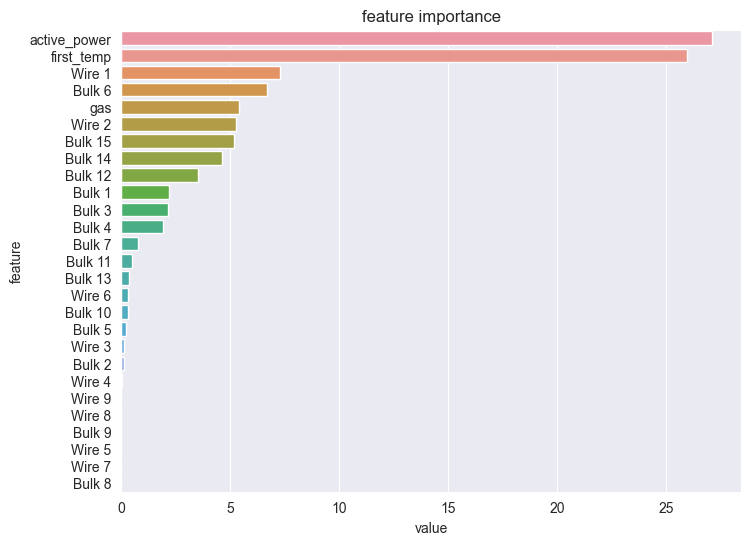

In [57]:
importances_array = pd.DataFrame({'feature_names': np.array(features_train.columns),
                                  'feature_importance':np.array(model.feature_importances_)})

importances_array.sort_values(by=['feature_importance'], ascending=False,inplace=True)

plt.figure(figsize=(8,6))

sns.barplot(x=importances_array['feature_importance'], y=importances_array['feature_names'])
plt.title('feature importance')
plt.xlabel('value')
plt.ylabel('feature');

In [58]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
print('Результат константной модели MAE на тестовой выборке:', 
      mean_absolute_error(target_test, model_dummy.predict(features_test)))

Результат константной модели MAE на тестовой выборке: 7.468038177819408


<b>Комментарий: Показатель константной хуже как полученного результат на тестовой выборке, так и требуемого порога</b></font>

## Заключение

<b>В ходе выполнения проекта был проведен анализ данных, которые предоставил заказчик, затем были выделены необходимы для обучения признаки, а также целевой признак. Данные были собраны в один датасет, с которым была проведена предобработка данных и исследовательский анализ. Все это включало удаление выбросов, заполнение пропусков в данных, построение графиков распределения и вычисление корреляции между всеми признаками включая целевой. После была проведено обучение выбранных моделей, кросс-валидация, а также перебор различных гиперпараметров. Выбранная лучшая модель, CatBoostRegressor, имела показатель метрики MAE на кросс-валидации 5.81, что на ~1 выше порога установленного заказчиком. CatBoostRegressor показала 5.61 на тестовой выборке, и гораздо лучшей результат, чем константная модель. По всему вышеперечисленному, делаю вывод, о соответствии модели требованиям заказчика. </b></font>